In [109]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
def findFiles(path): return glob.glob(path)
print(findFiles('*.input'))
all_letters="ATCGN"
n_letters = 5

category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [line.upper() for line in lines]
for filename in findFiles('*.input'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
n_categories = len(all_categories)

['atis.input', 'dtis.input', 'utis.input']


In [110]:
import torch
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    #turn a sequcence to a tensor
    #size [seq_length,1,base(include N)]
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


In [82]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories).cuda()
#rnn = RNN(n_letters, n_hidden, n_categories)
print(rnn)

RNN(
  (i2h): Linear(in_features=133, out_features=128, bias=True)
  (i2o): Linear(in_features=133, out_features=3, bias=True)
  (softmax): LogSoftmax()
)


In [79]:
input = lineToTensor('ATCGTTA')
hidden =torch.zeros(1, n_hidden)
#print(n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output)

128
tensor([[-1.1299, -1.1414, -1.0285]], grad_fn=<LogSoftmaxBackward>)


In [80]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('utis', 2)


In [83]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    #print('category =', category, '/ line =', line)

In [104]:
criterion = nn.NLLLoss()
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden().cuda()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [ ]:
import time
import math

n_iters = 10000
print_every = 20
plot_every = 20



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    category_tensor=category_tensor.cuda()
    line_tensor=line_tensor.cuda()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

20 0% (0m 15s) 1.0318 TTAGCATCTTCATTTTTCTTTATTTTGTTGACTTGCATATTTTCATTTACAGGCTAGCAATTAAAAAAAAAGAGAGAAAGAAGGGAATTTTTAATCATAAGTTTACCCTAAACTAGGAACAAAATGCCTACCATAGTGAGATGTCAACATGCATTGCAATCTGTTAGTAGGCAGTGGTGGAGTTGCCAGTTTTGTACAAATAGGACAATTTAAATTCGCTGCGGCCAGGTCCCCAGGTGTCAGGTTAAACAGACACATATTATCTCACCAAGTGGGTCTGTCTGGAAACCTCTTTTCTTGAGCAACATGGTAGATGTCATCAATAAAATACACCCACTTCTTTCAGTTCCTGCATACATTATTTACCGAGTGCCTATTATTATAAATTATTTACGGTGTCCCGAGCACACGACACCGTAAATAATTCTAGTTCGGCAGCAGCAGTTTGGGCGGCTATCCGTTCAATCCCTTGGCCACCTGAGCGTTGTGAACTCAGGAAGGGGGCGCTTTTGTAAGCTGGCCAGCTGCTCCAGAGAAACACTGTGCTAGGCTCTGCCCTTTCCAAGATCGGGGACATTCAAGACCGTTTTCAAGCAGCGGGCAGGAGGGGAAAGCATCTGTACGCGCGACTCAATAACGTCGCACCCGGGCCGCTGTAACATGGATCCACTACGGGACCAACGGACTCCTGCCCCTAGAAACAGGGCAACAACGCACGACACCCTGGAAGCCGGGTCATACTTCACTACTAGCACCAGAAGGGGCTTCCGCCTCTCCACGATCACCCCGGAACCGGGAATGGAGAATATGGGCTCCCAAGCCGGTCGCCGGCCTGACCGCAGCCCCAGAGCTTCACCCGTCACGGGCGGCCAGAGAGATGCCCGGGCCGCGCGGAGGCTCCACCGCCAGTCCCCCCCGCGAGCCGTACCTGCAATGGTGACACTTCCATGGTGACGGTCGTGAAGGGGCTCAAGAACC

120 1% (1m 32s) 1.2039 ACCTCAGCCTCCCTAATAGCTTGGAGTACAGGCATGGGCCACCATGCTTGGTTAATTTTTAATTCTTTGTAGAGATGAGGTCTCACTATATTGCCAGGCTGATCTGAATTCCTGGGCTCAAGCAGTGCTCCCAAAGTGCTGGAATTACAGCACTGGTCTCAAACTCCTGACCTCAGGTGATCCACCCACCTCGGCCTCCCAAAGTGCTAGGATTACCAGCATGAGCCACCATGTATGGCTTAAACTAGCTTTTGAACAAGCTTATAGGACAAGTACAAAGAACCCCACTAATTTATGCTTGTAATTACAAATACGTTTCATGGCTTTAGAAATCTAAAGAGATAGGTTAGTAGCTTTATGAGCCACAACGCCCGGCCTTGTTTGTTTTTAATAGAAACAGGGTCTTGCTCTGTTGCCCAGGCTGATGTTGAACTCCTGGCCTCAAGAGATTCTTCTGCCTTAGCCTTCCAGAAGGTTGAGGTTGTGGGCATTAGCCAGCTTGCCCATCCCTGGTATTGTTTTTCATAGCAGAACATTAGAAACCACAGATTAGAATATTATACGATGAGAAATATACAGCCACTAAAAATCATGTAGCTCCGTATTAGCGTAAAACGATGTCCACAATATATTGCTAAGTTGAAAAGATATTATAAAACAATACGTATTATGATACTTTTTTGTGTGGGTCTGTAATTTTATACACTTAAAATCTAGAAGAATCTGTAATGTTAATTAGTGGGATTATAGGTAATTTTTTTGCCTTCATGTTTGTCTTACATATTTTTACTTAGAGTGCTTTTTTTTTTGAGAAATAATTACATACTGTAAGCTTTTGAGCTTTTTATATTTTGAGTAAAAATATTTTTTACTTTAAGGTTTTTGTTCTCTCTTCATAGGTCTATTGAATTTAATTGCTTGAGTTTTTTTCTAGGAGGGAATCCTATGGCTGTGGTCAGCAAACAAGTAAATATGGA

220 2% (2m 49s) 1.1095 AGCTGTTTACACTACCAGAGAAAAATCTGGCTCCCATCCAACCCTCACCCACGAGGTGCCCATTCCAGACATGGGGCAAGCTGCCTTCTCATCTTCCGCAGGTGACAGCTCGGCTCACATTTGTCCACGTCTTCCATCTCGTGCGCTGGCAACATACCTAAATGATTACTGGAAGAGCTGCCTCTTTTTATAATTTCCTGACAGAATTTATAAAATTAAAATATTTAATTAAAGACAGAATCGGGGACATGTTGCCTTCACATTTGCTGTTCAACCTGTGCACATTTTGGTGGTTCCCAAGAATCGTCATGCCAAAGCATCAGGCTTGAAAGGAGAGATCACCTTAAGCATCAAGATTTAAAAAAATAAAACACAACTCTCCTCAGTCTAAACTCTAGGATTTGGATGACGCTTCCCTGTCAAGGTTTCTCCCGAGTGGAGGAGACAAGAGGCAGGAAAGGCAGGTAACTAAAATTGCCTCATGTAAAGGGGCTCAGCGCAGAGGAGGAATGAGATAATAGCGGCGGTGGGGGTCTTTTCCCTTCTCTCCCTTTCTATCTTGGAAACAGGGGTCCGACTGGCAGCGGAGTGGGGGCAGTCCAAGCTCCGGGGTACCTGCAGGAGGAGACTCGACCAGCGAGAGGGGCCAGCGAGGGTGACCAGGTGCCCGCTTGGGGACCCCGCCGGCGGTGGCCAGGCTAGCCCAGGTCCTCCCCGATCCCAGGATGCACTGCGCCCCGCCCCCTCCCCGCGCCGCGTTCCGCCTCCCCTCGGCCCCGGCCCCCTCCCGCCCAGCGCGGGGAGGCGGGGACGCGTCGGCGGCGGAGGCTTCTCCAGTCGCGTCTTTCTCACTCACTGGGGAGCCCGGCGGTGGCGGCACCTTTCGAGGTAGACCCGCTGAGCTGCTAGCCCGCCGGCCAGCGAGTGAGAGGTCGGACAGACTGTGGAGCCGACAGACTGAAGGACAGCGGCACCGC

320 3% (4m 6s) 1.0561 GGTGCGGGCGCGGCGGCGGCGGCGGGCGGGGTGCGAGCCGCGCTCTGGCGCACACACTCGGCCATTACGGCCGGGGGAGGGGCGGGGGGCGCGCGGCCGGGCCCTCCCCTCCGCGCCGCTCCCCTCCCCCCGCCGCGGTGGGGGCCGCCCGAGGGCCCACCCGCCCGCCACTCCCCGTCTCCCTCCGCGCGGGCCGCGCGCCCCGCCGCCCCCGCACGGAGAACGCGGGGCTGTGAAAAGAGAGAGGAAAAAAAAAGTTGCCTCGGAACTGCTGCGCCCAGCTCCCCCGCCCGCCCGCCTTGTTTTCTCTCCAGCCAGCAGCGCCGGGCCCGAGTCAGCCATGTTCCAGCGAGCGCAGCGGCGCCGCTCCCCCCGCCGCCCGGCCGCCGCCGCCGCCGCGACCGGGCCGAGGCCGGCCGGGCCCGCACTGCCGCCCCCAGGCCCCCGCGCCGCCCTCGCCCGCCGCGGCGCCCCGCCCGCCCCGCCGCCCGCCCGGCTGGCCGCGCTCCCCGCCAGCGCCCGGCTCGCTGCGGCGGCGGCCAATGCAGCCCGGGGAAGCGCCGCCGCTGCCCTCCCGCCGCCGCCGCCGAGCCGCGCCGGCCCCGCCGCCCCGGCCGCGCTCCGCGCACGCCGCCCGCCCGAACGCCCGGCCCGAGGGCCCAAAACACGTTCAAAATTTTTTTAATTAAAAAAAAAATTTTTTTTTTTGCGCCAGTCAGCGCGGACGCCGCCGGGGGTGGAAACTCGCGGGGCGCGGGGCTCCCGGCGCCTCAGGCTGCCTGAGGGCCGGGGCACCGGCGCGGGGCAGCGTTCCCGGCGCCCGGGCAGAGGCTCGCTCCGTGCGCAGTTCCCCCCACGGTCCCCCCTCATTTGCCTTTGTGTGGATCCTGACCCGCCGGCTCCCGGCCGCGGGGATCCGGCCGCCGCGCGGGCTGGGGAGCTGCCGGAGGCGCTCTCCCCGCCGCGGCGCTGCCCCAG

420 4% (5m 23s) 1.1783 CCTTCTAAACTTGAAACCTTCCAAACTCACCACTTGGCGGCGTTGATCCATCCGCCCGCGCACAAAGAGAAGATCGCGGAACTTCAGAGTTAAGGGGAGCCGTTTCCCGCAGCGCTAGCCGGCAGTATTTCCAAGGCGCAAGTTGCGGAGTTTCTGTTTCCTTTTTCCTCTGGCGAGCTTTGCGTTCCCTGTGCGCCGGAAGTGATCCCCTGCGTGGCTGGGCTGCTCGGGTTAGATCGTCAGGTGAGGGAGGAAGGGATAGCCAGCGCGAAGGAAGTGCTGGAGTCGTGTGTTTTGGCTGCGCGTGATCCTGCGTGGGTCGGGAGGTGTTTCTGTGTAGGTGTCTGGCCCTTTCATCAGTCGTGCGGAGGACCGCGTGATTTCCTTCCAGTTCTCCTCGGTTTTCAGGTGGTGGCGCCATCTTCGGTAAAGGGTGTCCACCTCTCCCTATGGTGTGGCTGGCTAGCCCGGGGGTCTCTACGCTGCTTGGTCTTTGTTAACGGAGATGAAGGCAGTAATTTTTCAGTAACAGGTTTCAGATATAAGTCCCTTGGTGATGCTAATATTTATGGAGGCCTTACTATGCATTAAGAACTTTTTTAGAAGTTTAGAAAATGGCAGTGAATAAAGCAGATACAAATCTCTGCTCTAAGGGAGCTTGCATAGTAATGAAATTTGAGAAGACAGTGGATTGGAAGTGGGATTAACTCAGAATCAAAATTTTGTCGATGGGTTGGAGGAAGAGGAAGTTATTTGGGACCAAAAAGACATACAGGTGTGAGTTTATTTGGGAGGGAGGAAGGAATCCTCATCAGATGTGCAGGAATGTTGGTACGTTGTGGTCACAAAATTGGAGTGCATAAAAATTATGAATATAGTTAGGAATTTAGGACTGGTGAGTTGTACTTTTGCCATAAGAGGTAATGTTTTTTTCTTATTTTGTTTTTTTCCTTCAGGAAAAGCCTAAAGATTAGACT

520 5% (6m 41s) 1.2835 GCGTGCGCAAAGCGAAGGCCGGCCGGGCGGGGAAGAGAAATGGCGAGGCAGGAGTGCGGGGGAGGGAGTGGTCCTTAGCTGAATGCGCCTGCGTTGTGGCGGCCTCCGGCGCCCCAAGGTACTTTCTCCCCAGCAAGGAATCCGCGTGCGCGTAAGCAGTATTGTTGATTAGTGCCCCCCCCTTCCCCCCGCCCGCCCCGAAAAGCGACCCCTAGTGGTGCACCGGTGCGGACCAGAAAATTGCACGCTTTCTTGAAAGAGGCATTTACCGAGCGCCCAATGTATGCCTGGCACTGGGCTGGGTGCTGCCACCTAAGCGAGCACGACCAATGCAGTCTATCAGGGAGGCCCAGATCGCCAAGCAGCGGACCCCTGCGGTCCGCCATGCCACTCCCGGCTCCTAGAGCGCCGCTCAGCACACCGTGAGCGCCCAATAACTGTTGGGCTTCAATGACGCCGCGGAGGCGGCCCCGTCCCCGCGCTCCCGCCCCTCCCGCCAGGGCAGCCCGGGAGGCCAGACGTTGACGCTGCAGGGAGAGGGTGGTGGGCGCAGCCGCTAGGGGGCGCGGCGGGGCGGAGCGCACCTTTCCGCGGGCCGCGGGGATGGCGGCGCAGGGCGTAGGGCCTGGGCCGGGGTCGGCGGCGCCCCCGGGGCTGGAGGCGGCCCGGCAGAAGCTGGCGCTGCGGCGGAAGAAGGTGCTGAGCACCGAGGAGATGGAGCTGTACGAGCTGGCGCAGGCGGCGGGCGGCGCTATCGACCCCGACGTGTTCAAGTGAGCGGGGCGGGTGGGGGCCGCATGCTAGCCAGACACCCCCCGACCTCTGCTTTCCGGGTACGCCCGGCCCGCTGGTCGGGAGGAGCCCCCGCCCCCGTCCTTGTCGGGTCTTCAGGGAGGTGGCCGCGCCGGGCGGAGAGGGCTCACCGGCCCCGCGTCTGTCCCCGCCAGGATCCTGGTGGACCTGCTGAAGCTGAACGT

620 6% (7m 59s) 1.1300 TGAGATTCCACCACTGTACTCCAGCCGGGGCGACAGTGGAAAGGGTGCTAGAGGTCATTTCCTGTGTCTTAATGTTGTTACCCTGACCCCAACAGGTAGACAAGGGCGTGGTCCCCCTGGCAGGGACAAATGGCGAGACTACCACCCAAGGTGAGAACTGTTTGATTCTCTGCCCTACGAACCCAACCAGAGCAGGTTTGGGTGCTGGGAGGAGTGGAAACCACATGCCCCTCCCCACCGTGCTCTGACCCCTTCCTCTTCTCTTAGGGTTGGATGGGCTGTCTGAGCGCTGTGCCCAGTACAAGAAGGACGGAGCTGACTTCGCCAAGTGGCGTTGTGTGCTGAAGATTGGGGAACACACCCCCTCAGCCCTCGCCATCATGGAAAATGCCAATGTTCTGGCCCGTTATGCCAGTATCTGCCAGCAGGTGGGCCTGCAGGTCCTCAATAGGCAACCTCCTACCTCATTTGGTTCCAGTGTTGTTAATTTGCCTATTACCTGCCATGATGCCTACCTCCCCAAAAGCAAGCATTAGCTTTGGCCCGTGGAGGACACTCAAGGGCTGTTGAAGGCAGAGGGGCCAAGGAGGGATGGTGGGTGGATCTGAGGCGGCTCTTGTCTCCTGTAATCTGAGGGCTTTGAAGCCTGAGTCCCTGGCATCATCAAGATACGGTCTTGACCAGTGGCTGTGGAGAGATGTAGGTGGGACTCTGGGTTAGGAGGCCTCACAGTGACCCTGTCCCTCGCCCTGCAGAATGGCATTGTGCCCATCGTGGAGCCTGAGATCCTCCCTGATGGGGACCATGACTTGAAGCGCTGCCAGTATGTGACCGAGAAGGTAAATGGCTACCTGCCTGACCAGTGCAAGGTGGCTGGCCGGGGACCCTGGGGCTAACCCCTATCCTCTCCTCCACCCCACTACCCACCGTGCGCCTGCTCTGCTCCAGGTGCTGGCTGCTGTCTACAAGGCTCTGAG

720 7% (9m 13s) 1.2810 ATTTCCCTCTGCCTTACACGTGCAGAACTTGTGGTAGAGAGAAGCCCTAGTTTGGCCGTTCTGCAAGGGATAGCCCAGGAGGTAGGGGGAACCTTAAGTTGAAGTCACCTGAAGCATGTTTGGGGTCAGGGAACTCGGAAAGCAAGAGTGTGGCCACAGATCTGCCCAGAGGCGCGACCCCCAGCTGAGGAGACCAGATGGCGGGAAAAAGCGGGGGTCCACCGACTCCGCGGCTATCTGTAATCCTACCCTTGGCCAGGCCGGGGAGCCAAGAAAGACTTCCAACACTCCCCAAGTTTCAGCTCAAGTCGTCTCCGAGGCTGCGTGTGCCCCAGCCTCGCACGCCTCCCTGCAACGTGGCCGCATCTGGGGCGCCCTCATACCCTCAGGGTTTCCCAAACTCTTCCATTCTCTTCCCAGGCCCAGCCATGTCCCAGGTCTCCGGGTCCCCGGGTTCTCCTCTCCGCGTGCCGGGAGAGTCTCCAGCTTCTCAGACTCCAGCAACCCCAGCCAAACCTCTTCGCTGCCTGGAGCCTTGGCTCCCGCGACACCGCCCGGCTGCGGGGCGGGGGCAGGGCCAACGGCGGAACCGCCCCCAACCGCCTCCCAGGCCAGGCGAGCAGGCGGGTGGCTGGGGCGCCTCCACCTCCTCTTCCTAAAGCGGCGAGGCGCAGAGGAGCGGCATCACTCGAGCCCAGGTCCCAGCCACCACCACTCACAGCGCTCGGCGTTCAGGAAGAGGAGCAGCAGCGGAGGCGGCTGCTTCAGCGGCGGGCGGGCGCCAGAAAGGTAGACTGAGTCCCAGGGAGCTGCGCCGCTAACAGCCCACCTCCTAGCCCCGGGCTACGCGCCGCCAGCCCAGTAACCCCACTTTTGTGTGTCCTCCCAGGCCCCGATCGAAAAGCCTGGGAGGGCCGCCGAACTACCCCCGGAGGGAGGAGCCAGTCCGAACCCAAGGCGCCACCGCCGCAGAAGCG

820 8% (10m 28s) 0.9997 ATTAGAGAAGCCCATTCTCTTGTGCATTAGAGATAATGCTTAGGCGTTTTCTTGGCCTGAATGAAATATTCCTCAGGACTCTTGATTTTTGCACTCATCAGGCAACATTTTTGACTTATTAGTTCAGCTTCCTATGGTCTTTTATTTCAGGGATGGTATGTTTTGATAGAATATGTACACTAGATCGTTTATTTCTTTATTATAAATAGATAAACTTGTAAAGTGATTTATGCATCAATACCATGTAAATTTGTTTAACATGTGTTCAACTGGGTACAGTGGTAAAATTACGTTTCTGGCTCTATAAAGCAGAGACCCAGACCCTGAACCACTGCCTTAATGACCTCTCTTTGTGTGTCAACTGCTTCTCTGTACTCATCTGACTTTTCTTTTTTTGTTTAAGAGAAATAATACGCATTAAAACTATACCAAAATCATATAGCATATATGTGGCATTTCTTTGAAGATCTTTAAAATGAGACAATAGGAGAATAAATGCGTGAGTTCTGGAGTTCAGTCAGTGAACTCTGAGGTTCTAGCCCCAAGATTCTGTTCCAGATTCCATTCAGCAACCTGCCTGCCACCTACTCTCACCCCCGCAGTTATATGAAGGAAACCAAATGAATGAGAAGTAAATTTTAAATTACTCCCTAAAAAGTGTTAAATTTTTATGTAACCAGAAAAGAGAGAATCTAGAACTCGCAATTTCCTAAGGAAAATTTGCTACCCGGACTCAAAGTTTAAATCTAGCTTTTTTTTTTTTTTAACTTCTTATTTTTTATGCTATCTCCTACAGGAAGGATAGCTTATTGTTTCTTTTACGCGTTTGGTGATTAATAAATATAATTTTAGCTCAAGTGTAATGTCATCAATAATTGACTGCAAAAATAAGCTGATAGAATTAAATTTTCAGTTTGTACCTTTCATTGGTAAAGTAACCAGAAATCTTTGTGGCTAATTTTTTTTATGTTTCATT

920 9% (11m 43s) 1.0029 TTGTGAAATACTCACCTCAATCAACAGTTACCTTTTTCTTTTTTGTGGTGAGAACACTTAGAATCTACCCTCTTAGCAAATTTCAAGTATACCATACAATATTGTTAATTATAGGGAGTTCCGAGTTTTTAGTTGATAGTACGATGTTAGAATCTTTTTTTTTTCTTTTTGAGTCAGGGGCTTGCTCTGTTGCCCAGGTTGGAGTGCAGTGGCGCAATCTTGGCCTCCCAGGCTCAAGCGATCCTGCTACCTCAGCCTCCTGAGTAGTTGGGACTACAGGCATGTGCCACCACACTCAGCTAATTTTTATTTTTATTTTGGTAGAGACAGACTTTTGCCATGTTGTCCAGGCTGGTCTTGAACTCCTGGGCTCAAGCAATCCTCCTGCCTCAGCTTCCCAAAGTGTTGGGATTATAGGCATTGACCCACTGCGCCCAGCCAGAATCTTTTTTCTTTTATTCTGATTCCTAATAAGATAATCATTATTATTTGCTACATCCGTAATAGTTTCAGAATAACATTACTAGTATCATTATATTAAAGAACCACCTTTCTTAGATAAAATGTAGTAAACTCTGTGTTCTCTCCTACACTTTGTTTTTTTTTCCCAAGACAGGGTCTCACTCTGTGGCCCAGGCTGGAGTGTAGTAGTGTGATCATGGCTCACTGCAGCCTTGACCTCCCAGGCTCAAGTGATCCTCCCACCTCGGCCTCTCAGAGTGCCGGGATTACAGGCTAAGCCATCACACCCGGCCTCTTCTGTATTTGCAGAAGTTCTAGGGAAGTAGGGATATCACCCTTTCCTGTGATAACAGGTGGGAAGAATTTCTCCAGGGTGGTTGTAGGGCTCTGGTCGCTGGTAGATGCTTCCTAAGTGGCGTTTTCAAGGTGGCCAGGCCCTGCCATTGCCTGCTCACCCTTGAGGTAGCTCTCTCTTTGCCCTAACCTCTCAGCTCAGGAGCATCTATCGGCTGCA

1020 10% (13m 0s) 1.0020 CTTGGCTCACTGCAACCTCCACCTCCCGGGTTCAAGTGATTCTCCTGCCTCAGCCTCCCGAGTAGCTGGGATTACAGGCATGCGCCACTACGCCCGGCTAATTTTTTTATTTTTAGTAGAGACGGGGTTTCACCAAGTTGGCCAGGCTGGTCTCAAACTCCTGACCTCAGGTGATCTGCCCTCCTCGGCCTCCCAAAGTGCTCGGATTACAAGCGTGAGCCACCACGCCCGGCCTAAACACAATAAACTCTTTACAAAAGATAATAAAATACCAGCCAGCCATGGTGGCTCACACCTGTAATGCCAGCACTTCGAGAGGCCGAGGCGGATGGATCACCTGAGGTCAGGAGTTCAAAACCAGCCTGGCCAACATGGTGAAACCCCGTCTCTACTAAAAATACAAAAATTAGTTGGGCATGGTGACATGCACCTGTAGTCCCAGCTACAGGGGAGGCTGAGGCAGAAAAATCGCTTGAACCTGGGAGGTGGAGGTTGCAGTGAGCCAAGATCCAGCCACTGCACTCCAGCCTGGGCAACAGAGCGAGACTCTGTCTTTAAAAAAAAGAAAAAAAAATAGATAATAAAATGCCAAATAAATTTAACACTTGCTTAAGTCACAATATGAAAAGCTAATAAAATGCCAAATAAATTTAACACTTATTTAAGTTACAACATGCTGAGTTCTGGATATAAATCTATTTGCCATAGAATGGAAGATTGCACATACAAGGAGGGCTATGCCTCGGATGCCATCCAATTACCAAAGAGCCAAAAGGTGCATTATTAACAAATTTTTACCTACAAACAATGCTCCAGAAGGTACCCCAATAATGTTACAGCAAAGCTTCGGTGTATGTACCCCTTTTTAAAAAAAGGTTTAGACAGCTATTCCCATATTCAAGGAAAACACACACTCCCTAAGCAGCACACAGTGAAAAGCCTGGTTATAGGGAGACATAATACATACCCAGAGCT

1120 11% (14m 15s) 1.0555 ACTTTGGGAGGTTGATGTGGGCAGATCACTTGAGGTCAGGTGTTTGATACCAGCCTGGCCAACATGGTGAAACCCAATCTCTACTCAAAATACAAAAATTAGCTGGGTGTGGTGGCATGCGCCTGTAGTCCCAGCTACTCAGGAGGCCTAGGCTCCAGAATTGCTTGAACCTGGGAGGTGGAGGATACGGTGAGCTGAGATGGCACCACTGCACTCAGCCTGGGTAAAAGAGTATGACTCTGTCTCAAAAAATAAATAAATAAACAGACCTCGTACAGCCTTCCAAAAGTAGCACCAAGTATTAATATCTCAACTTTTGTTTGCTTCGTTTTTAATTTTTTTTGTTTTTAAGAGACGAGCGTTTGCTATGTTTCTCAGGCTGGTCTTGAACTCCTGGGCTCAAAGAAACAACTTGGCTCTGCCTTCCAAGTAGCTGGGGCTATAGGCATACATTACTGTGCCTGGCATTTGTTTGCTTCCTTTGTAACTCTTTAAATTTCATTGCAATTACAGTTTGCAGTTATTTATCAGTTTGCTGGCTAAATTTTTGTGTTTCCCCGGTAGACTGAAGGGTTCTTGAGGGCAGGAGCTGTGTCTCTTTTGGTCTTGATTGTTTCCTTAAATAGTCGCTGAGCAAATATTTGTTGAATAATGCATCAGCAGATGACTGAATTTAACTGTGAAAGCAGTTGTTTTTTTGTAGTTCTGAGGGGTGGCCCTTGGCCCTTGTAGGTGAGTGGTAAGCAGTGTTGAGGGAGGGTCTTCTTAGTTCCAGAAACCACAGGAAGCTGCACGATGGAGGAATAGGAACCAGTGGAAGACACACCTGTGTTAGAATGAGGACACCAACAGGGTTTCATGGAGCTTTGTGTTTTGAATAATGCCTGTTTTTTTATGTGTAGTGAATGATGCTACACTCTGGGTGGACTTTGCCTAAGTTTCATAAATATTTAATTGGCTTTTTCAGGAGAATA

1220 12% (15m 32s) 1.1958 AGCGCTGAAGGGCAGAGATCAACTCTTCCACTCCATAGCCGGTCTTGGCGCTGATCAGCCGCACGTCCCTGACCACTGTGCGGGACCAGTTCGGCGGATTCGGATTCTCCCCGTCCTGTGGCTCGTCCTTGACGGGGCGCTGTGGCCCTTGGTGGCCAGGGGCCAGCAGGAGCCCGGCGCGGGCACAGTCCTCCCACAGTCGCTCCCGCAGCCTCTGCCGGTAGCCAGGAGCATCCTGGGGCAGGAGGTCCACTTTGTTTCCCAGCACGATCAGCTGCTTGGGGCCCACCAGCGCGGGCAAGTCGGGCAGCAGGGCGTCGGGCAGGTCCAGCAGGTCCACCATGTAGAGCACCAGGGAGGGGCCGGGCCGCCGCAACGCGGCGCTCACCAGCTCCAGGTACTGCTCGCGGCTCACCTGCAGGCGTAGAGCGCGCCGGTGGTGCGACAGCAGCCAGCAGCGCTGGCACACGGTCCGTGCCAGCCCGCCGTCTGCCTCCGCCGTGCGGAGGAACTTCTCTCGGGGCAGGTAGCCGGGCACTCCGGCGTCCTGGCAGTGCAGCTCTGCCCCACAGCCCGAGCAGTTCACGCCGCTGGGCGGCAATGCCGGGTCCGGGTGCCCCACGACCGGGTGCTCCCGGGACCTGGCCCGTAGGTTTTGCTGTCGCCGCTCCTCCCGCCGCTGCTGCCTCTGTCGCTCCTCCTCCTCCTGCTGTTGCTGGAGCTCCTGCAGCTGCTTTTCGCGGGTGGGTTGCGGCTCCGGATCCAGGATGTACTCCGGGAACAGAAAACGCTCCTGCATGTCACCACCTTCTCCAAAGCCCTCCGTGTCCACGGGGTCATAAGGAAGCTCGCGTCCCAGACTCGATGAGTGCTGGAAGGAGGAGGCGGCAGCGCACCTCCTCTCCAGGAGCGGCTCCCGGAGGCCATGGCGCGCTGCCGTGGGAGCGGATCCACGAAGGAAAAGGCTCAGCAGC

1320 13% (16m 49s) 1.1267 ATCGCTTAAAGACCCACAGATGCCTATTTTTGCCAAGTTCTTGCGTATTACACCAAATAAAATACATGACCCATTCTCTGAAAGAGACACTTACGCTGTATAAAGCACAGGTTTGAGAAACCTCCCTTTCCAAAACAAGGAAGTCTGATACATCTGCTTACCAGTGTAACACCCTTGATCATGTTCTGTACATGACTACAAATAGTCCGAACGGTAGCCAGTTCCTTTCTGTTACCCCACCATTTGTCAACCCGGAGCTGTAACAGAACAAAAAATGTATTCTTTCCAGAAATATGCAGGCTTAAAAGACAACAGACCACTTACCGAATTACTTTAAGATTCTAGAATTAACCCTTATCAAAGCACATGGTTTTCAACTGGAAAAATCCAACCACCTATAAAACCTCCCAACAGTTAAGCTTTGTAGAAGTTGCAACAAACTTCCCTTCTGGAAAATTAAATCATCAGGTTTAAATGACCTACTGCCGGTTCCTGTGATTTTTACAAAGCAATCACTAGGAAAATAAACCAAACTTCTAACACCATTAAGACGTGTCACTGATGACCACTATTACATTTGAGCTTTATATAATTGGCTGTGTTCAGAATCTGGTTTTTCAATTTCACTGAACAGGCTGGTATTCTGGACAGCAACATTTAAAGCTGAAGCACTGAACCTTAATTCGAAAATTGTTAAAGCAACCAAATGTGATGCTGTTATAAACCACCTTCCAACGAGCAACTGAATTATCAGAAGAAAAACCCTCACCCTCTTTTTTTTCTTTCCAAGAAGGCTGAGTTCTACATTGATGTGATTGAAGTCCCTCCGCAGGGTTCCTCTGGGGCCCTTCACGATAACTGTGCGTCCCTTCAGAGTAATGTCGACTAGAAGAGAGAACACACTCGTCAGGCCACACAACGCTTGGAACGTGCAGTAAAGATGTAAGTAAAAGACATCAAGTCTCATACCATTT

1420 14% (18m 7s) 1.0292 CCCCAAGAACACCAAACCCACTCTCCCACTCTTAATCTCACAAGTTAGCTCCCATTTCAGGCAAAGAATCCCAGAGATTCACTTCAGATAAACTATCTTTCCACCTTTGATTTCTGTCTTCGTCCCCAACTTCTATCTCAAATCTCACCCCCTCTACCACCCAAACACCAAGCAAAAAAAATCAAATCAAGATGATCAGAGGCCTAAGGCTCAGGAGAGGGGAAACCAAGCCTCCCAGGCCGATAACCACCACCAGAAAAGTCAGCATTCCCAACAGGCTGACTGACTGACACTCAGAGGTCAGAAGAACCTCCCTAGAGCAGTCAAGAAGGGATGCACTAGGGGGGTTAGGGGGAGGGGAAAATCGGAACTGTGCCCCCAGCTAAACAGGCCCCCAGAGAAACACGAGATTTAGCTGCTTACATCTAGAGAAAAGGCTTATACAAAAAAAATATCTATTTCCCATACAGAAAGGGCATGTGGGGCCAATTAGAAACTGGGCAGGCAGGACAAAGGGGGAAGGCAGAATGACTGAAAACAAACCAAAACGAAAGACGGAATGAAAGCCATGAGGAAGAGAAGGAAGACGAAGGGAGCTAGGGCGGCGGGGAAAAGGCATACATGGAAATGTGAAGCTCTCACCCTTCTTTGCTTTCTGATAACATGATTTTTTTTCTCCCCCTGGAAGTGCTGTTTATCCCTTTCTGGAATGGAAGAAATAACAAAAACCAAACAAAAAAAATCCTAAAAAAAATAAAGAAAAAAAACCACACCTTCCTTGTTCCAAGATCCCACCACCTCCTCCCCAGCCACCCGATCCAGAGAGAGAAAATTGAGATGTAGCAACCGGGGATCCAAAAAATGGTAAATGGAAGGGGAGGTGGTGGTGGTGCGGGGAGGCTAAAACAGATCTGGCTTTTAAGAGATAAGCGTTAAGTCCTCACGGCAAACCCCGAGTTCGGCTGGATTGGTCTC

1520 15% (19m 20s) 1.1051 CTGTGTATACCCTCGTCTACTACCACCATACGTACCCCCCACCACTACCCTGCCTTGTCTATCACCCCCCAGGCTGTGACATACCAGGGATGTTGCCAACGAGCTGGTCTAATCTGGGGTGAGGGTTTCTGGGTGCCCCTAGACACCAGGAGAAAGGCGGGGAGGGGACACCCCTGGGGGTCTGGATTCACTCCACCAGGCGCTGGGCCACAGTGGTACGGTGACACAGTAGATGTCTTGAGCAGGATTAAAGTCTTCCCAATAAACAGGCTGAACTCTGTCTTCCTTGAAAGCTCTGTAGAAGGACCTCACAAGGATAAACACAGCGAGACCCTCCAGGGCGCGGTCAGCCACGAGCCACAGTGCTGGGCCTGTGACATCTCTGGAGGTTCTGGGGTGGAGAAGGACCGGCCGTGGGGAGTGACTGGCTGGGGAGAAGCTCAGCTCCCGCCCACCTCTGGGAGGCCCGGGGCTGGACGGGAGGTGCAGCAGACAAGGCTCCGGGCGGGTGCTGGGGTGTCTGGAGGGGTCCCCGCGGGGGGGTCGGGTTGGGTGGGGAGTCTAGGTGAGTCGGGGGTCCCCGGGGGCGCTGGGTTCAGGGTGGGAGCGGAGTGTGGATGGGGCAGGGTCCCCATGCCCACCACCAGCCGCGATTCCACCGCGCCTACTCGGGGTTTCCCCGGGAGGACACCGCGTGTGTCAAGGGCCGGGGCCTAGAAGGCGGCCGCGCCCAGGGAAGCCTTGACAGGGAGCTATCTGGGGCGGGGGCTGGGGTCGCGTGGCCAGTACCTGGGAGAACCGCCATTCAGGAGAACCCCCCGCCAGGCTCTTGGTTCCGCCCACGCAGTCCCGCCCCCTCCCCCAGCCACGCCCCTCGCCCCGCCGCGCAGGCCCCGCCCCGTCCCGCCAGGCTCTCGGTTCTGCCGACGCAGGTCCCGCCCCTCTCGTAGCCTCGCCCCGCCCGCCGCGCAGGC

1620 16% (20m 33s) 1.0903 TAAGCCTTCCACAGAGCATTTGGGCATAGATGTAGTTCGTCCAAGTTCTTTGTCAATTTAAGACAAGGATGGCCTTTACTCCAGTTTCCAACATGTTGTTCCTCATTTCCATCTGGAACCTCACTAGAATGGCCTTTACTGTCCATATTTCCATCAACATTCTGGTCAGGACCATTTAACCAATCTCTGAGGAGTTCCAGACCTTCCATAGTCATCTTGTCTAATAAGCCCTCATCAGAATCTTGGTTTTTTCTAGCCTGCTCTTCCAAATTCTTCCAACCTCTGCCCATTACCCATTTCCAAAGCTGCTTCCACATTTTTAGGCATTTCTTATCACCAACACTGTACTTCTCAGTATCAATTTTCTGTCTTAGTCTGTTTTGTGTTGCTATAAAAGAATACCTGAGTTTTTCCGTCCACTACCCCCATCCCCCCAGCACCACTTTGGCTGCCCTGCGCTCACTCTGAGCTCTGGGCTCCTGCTAATCTAGCGCCGCCATTGTCTCCCTTCAGCCGTCATCATGATTATCTACTGGGACCTCATCAGCCACAGTGAGATGTTCTCTGACAGTTACATGAGCCAGGAAATTGCAGACGGGCTGCGCCTGGAGGTGGAAGGGAAGATAGTCAGTAGGACAGAAGGTAACATTTTTGACTCGCTCATTGGTGGAAATGCCTCCGCTGAAGGCCCTGAGGGCAAAGGTACCGAAAGCACAGTAATCACTGGTGTCGATAGTGTCATGAATCATCACCTGCAAGAAACAAGCTTCACAAAAGAAGCCTACAATAAGTGCATCAAAGATTACATGAAATCAATCAAAGGCAAACTGGAAGAACAGAGACCAAAAAGAGTAAAACCTTTTATGACAGGAGCTGCAGAACAGATCAAGCACATCCTTGCTAATTTCAAAAACTACCAGAAAACATGAATCCAGATGGCATGGTTGCTCTGCGGACTACTGTGAGGATGGTGT

1720 17% (21m 49s) 1.1421 TACATTCCCTTCTGGTGACATCATGGGGAGGCTCCAGGGAGGCTGGCCAGTAGCAAACTCACCAAATAAGGCTGGAGGCTCTACAAAAGGAGGCAGGGCCTAGTGGTGCCTGGCTAGTCTGGAGGGGGTGGGGCCCCAGGGGGACCCTCCAAGGCCCAGACAGGCAGGAAATCAGCTGCCTCCCTGGAAGAGGAAACCTCTGCTTTTTCCCACAAGCATGTTAAACAATTGACCGAGGTTTGGGCCCAGCTGGGAGACACGCCCCTCCCTCCCCCCACTTTAAACATCCAAGAGCTGGGCAAAAAAACTAAAGTGCCTCCCACAAAAGAGGATTAACACAGGGAGATTTTTTTTTTTTTAAATAAATGGGGTTTCACTCTGTTGCCCAGGCTACAGTGCAGTGGCACGATCATAGCTCACTGCAGCCTCCTCCAACTCCTGGGCTCAAGCCATCCTCCCGTCTCAGCTTCCCTAGTAGCTGGGACTACAGGCATGAGCTACCACACCTGGTTAATTTTTTTTCATTTTTATTTTTTGTAGGGATGGAGTCTTGCTATGTTGCCCAGGCAGAAGACACATCTTTTAATAACAAAAGCAGCTGGCATCTGTTGCTCTGGTGCCCCATGCCAGGCACGGTCTTGGCTGCTGTAACGGCTCAATTACTTTTCTCCCCACAGGAAACACACAGAGGATTCCCAAGCAGGAATTCACAGCCGGGGCTGTCTGACTCCACGGCCCAAATTCGTTCCCCCACCGCATGATACTGACTCATTCCTTCTCAGCATACAGGATAAAGAACAGGAAAGGAGAGCTGCTGTTCAGAAAACCCCACAGCGCCTCTCTCCTATCCCTGGAGCCCAGCCGTGCGGGCAGACAGCTCACCTGCCCAGCTCCTCCCCCATCTCATAATGGTCCTCCACGTCCTCCTGCCTGAACGTGGACATGGCGGCCGGTCCGCCTTCCAGCAGCTTCCA

1820 18% (23m 6s) 1.2375 TGTCTTTGGGCGCTGGGGTCTCTCAATCACCAAAGATCGACATTACAGGCCAGGTAGCTCTTTGTCCCCCCAGAGGACTGTCCTGTGCCTTATGCTTAGCACTCCTGGCCTCTGCCCATTGGATACTTCTAGCACCTCCCCCGCAACACACACACACCTGACAACCCAAAACATCTACAGATATTGCCAAATACTCCACAGGGGGTGGGGTGGTGGCAATATATCTCCCTGTTTGAAGTCACTGGAATGGAAGTTAGGGGAGGATGGCTAAGTCAGGACTTGCAAAAAGGCTAAGGGACGAAAGCACATGGCTATATTAGACAAAGTTTGTGACAGACGCCTGTAGGTATATGGTAAGGAAAACAGATTAAAACACTAAGAAATAGTAAGAGGTCGGACCGAGGGTTTCTCATCTGTATGGGAAATCTCATCTCGTTCATTACTTTCAGAAACAAAAAGGAAAACGACTTTAAAGATACAGGTTAAAGGCCGAAGGGGTGTAGAACCACCCCCCGCCTCCTTCCCTCCATCCCTCCCAAATATCCCAGAACGAGTCAAACCTTTCGAATCTCGTAGCACAGATAACAAGCAACTCAGTAAGACTGGACGGGGATGACTGAGGGCCAACTCATTACAGGACTACAGGAAACTCCTTAGTCCTAAACCCGAATGCATCCGTGACCATGGTAACACTCCCTACCTGACCAAAAGCTATCAAACGCTCTGACAAGTGTTTACAGCTGCTTTCTCGATTACTGAAGTGGCTCTGAAAAGAGCCTTTGGGGTTAGGTGGTTGATCTATTGCGTCCCTTGCACACTCTTACTTCGAGCTGGTGTACTTGGTGACCGCCTTGGTGCCCTCGGACACGGCGTGCTTGGCCAGCTCGCCGGGCAGCAGCAGGCGCACGGCCGTCTGGATCTCGCGGGATGTGATGGTGGAGCGCTTGTTGTAGTGCGCCAGGCGGGACGCCTCTC

1920 19% (24m 20s) 1.0362 CGCAGCCCCTTTGGGATCTTCGTCAAGAAAAGGCAGTCGTTGACGGAGAAAAGACGGGGATGCGCCTTGGCCCTTTCTCCACGGGAATGCTCTCTGGGCTGCTGGCTGGTTGGGAAAGGGAGGTCTGGGCATGAGGGTCTAAGTTTCTTCAGCTTAAGGTTGGGGGGTCCCCGGAGTTTGGGGATACAGGACTTCCAAATTAGGGCTTTCTAAACAATTTCCCTGCAGAGGATCCCCTAGCAAACGGTCTGATACTTCTGAGGAGCCCACCTCCCTTGCACCAGCTCTCCGGTGATAAAAGTTCTGCTTTCCAGGCTCTAAGCGGTGGCCCCGGGAGATTCAGTCTGCCCTGAGTCCGGCTTCTCCCGCTCGCGGCGCGGGTTCAAGCTCCAGGGGGTGAAGGCAGAAGTCAACTGCTCATTCATTCAACAAATATTTATTGCGCGCCCGCTTAGTGCCAGGCACCGGAGGTGCCCCGAGCAAGAAGCCGCTCTCGCTGATCCGTTTCCGCTCCCCAAGTGTCCGGCGCGCGCCGTGGGAGCGCAGCCCGCATCCCTCGCCCACCGGCCGCCCGGCCTGGGCGTGCCCGGCTCCTCCAGCGCAGCCCTCTGTCGGGAGCCGGACCCCCGGGACCCAGCCTCCGGGGTATCAGCCGGGTGGGGAGGGCGGGAGAAAGGCAAAGTGCCGCCAGCGTCAAAGTCCCGCCGGCCCAGGAAGCCGCTCCAGGGAAGCGCGCGAGGCGGAGCCGCAGTCGGCCCCCGCCCGGCAGAGCGCAGAGAGCGGCGCGGGCGGGAGAGGCCGGGCGCCCGCGGCTCGGAGGCGGCCCCGGCGGGCGGAGGGTGCGGCCGGCGGGAGGGACTGGGGCGGCGCCAGGAGGGGCGCGCACTGCTGCGCTGCAGCCCGGCCCAGCAGGTGACCGCGGGCGGCGCGGGCACGGGCACGGGCGCGGGCGGCGCGGCGAGGAGGCGGCCCGC

2020 20% (25m 38s) 1.1485 AGTGTGTGGTGGGCCCGGCTAAGGGGAGCTGGGCCAGCACAGTCCTGGGAGCCAGAGGCTCCAGAGGCCCTGGGGACTCAGGGGGCAGGAACCAGCTCCCAGTCCCACGTGGCCGCTGGCTCTTTTCAGCCTCCCAATGCTGCAAGTCAGCTCCACAGCTTTGCCTACTGGGCCAAGTGCCTCCAGGCCCCCTGCATGGCCCTCTGTCCACAGCACCAAGTGTGAGTGACTGGGGGTCCCTCAGGGGCTGCCCCCACCAGGCTGTGCCAAGCCCTGATCCTCAGGGACTTCCTGGGGTGGGAATGTGGGCCTGTGAGAGTGGGAAGCCCGCCAGGAAGTTCCCAGAACCTGGGATCCTGGTTTCCAGTGCTTGCTGGGGCCACCCTCACTTACCCAGAAGTCCAAATTGTATTTGATATTCCGGAACAGGCCCCCCACCATTGCAGCAAGATGGATGACGTGTGTGGGTTGGACCTTCTCAAACAGGGCGCGGGTCTGTGCTGTATCCCTGTAGGAAGCCAGGCTGTCAGGAGGCTCTGGAGGGAACCAGCACCCCAGGGTTGGGTGCCAAGTGCAGGAACTGGGTGGGACTATGGCAGGAGGGACAGTCAAAAGGGAGGGTGGCCCCAGGGCCTGGCTGATATGAGGGTGCAGGCTTCCAGGAAGAGATGGGAGGGTGTTTGTTTTTCCAGGAACACAGCCAAGCACACCCAGGCCAGGCCAGCCACCTGGCAGGAAGGACCCAGAAACACAGCTACTGTTAGACTCAGCAACATGCCCAGCCTGGAACTCTTAGTTCTAGGGTGGGGGGTAGGATGGAGAGGAAGGGCTGATCTGGGGATGGGCTCACTCACGTGAGATCGGCGTCTTTAGAGGAGACAAACACCCAGTCCTCTCCAGGAAGTCCAGCTCCATCTGCTACCACCTTCTGGATGGCTTTGCCTACCAGCCCAGAGCCCCCTGTCACTAGAATC

2120 21% (26m 57s) 0.8915 TGGTTGCCTGGGAATGGGGTAAAGAGCAAGAAAGGGTTGGATTATTAAAAAAAATGAGGAAATTTTGAGGGGGATGATGGATGTGTTTATTATTATGATGTACTGGTGTCTCCATTGTGTACATATGTCAGAACTCATCAGGTAATGTACCTGATCAAGTTGTATAGCAGTTTATATGTCAAGAACACCTCAACAGAGCTGTAAAAAAAACACGACAGGTCTGACAGTTACCTGGGAAAGGTGGGGGAACAGGTGGTAGAAGAACACATTTTTTATGATGTTCATGGTACTTACATAACATAAATGAATAAAATAGGGCCAACATGGAAAAGAAAACAAAATGAAGGAAAATGTCAAATTGCCATCCTGAACACCAGCACCGCCTGTAATTAGCGTTCCTGGCTGCAGCCACATCTGCGGTCCTGCTCCTCATGAAGCCGTCCTCCGTGCCATGTCCCGGCCATGCCTGTCCTTAGCTTCCTGGTGCACACTGTCCTCCACCTTGTGTTCAGGCACAGGGCTGCTTGGCTCACCCTTGCTGCACCTGGCCTGTCCGTCCTCCCACCGCGGTGCCGCCCAGGCCTTCCCACTGCAGGGCTGGCTAACGGTGCATGGAAGAGACTCGAGTCCGTGTTGTGTCCTCATAGCCCACCGAGGAGGCAGCAGTGCCGGACATTTCGCGGATAGGTTGTGGTCTCTGAGTCTCCTCCTCTCAAGAGGATGAGATTTGTCTGTGTTATTGTCAAAACTCTTATTTGTCACGCCGCGGGTTATGTGTCAGTAACAAAAAGCTGAGATTTAGGCCGGTGTTTCTTACTGGTGCAGCCTTTAAATGCACACCTGCGAATGTTCAGTGCACCTTCCGCTTCCTGGCTCTATTTCAGTCAAACCTGAGGTCGTAGTGAAAGTCGGTGAGGAATTCTTTGGAACTTCCTGATTGGCTGTGTCCTTGCCTCCTTGTCTTCCCGCAGATT

2220 22% (28m 14s) 1.0983 TTTTATAGGATGGGCGTGGTGGCTCACTCCTGTAACCCAGGCATTTTGGGAGACCAAGGCGGGAGGACCGCTTGAGGCCAGGTGCTGGAGACCAGCCTGGGCAACACAGGGAGATCCATCTCTACAAAAAGTAAAAAAACTTAGCCTGTCGTGGTGGTGTGTGCCTATAGTGTCAGCTACTCTGGAGGCTGAGGCGCTGGAGCCACTGCACTCCAGCCTGAGCGACAGCGAAAAGCCCTGTTTCAAAAAAAAAAAAAAAACAAATCATTTTATAGATGAGGAAACAGGTTCAATGAAATCAAATGATTTCTCAATCTAGAGCTAGTTATTGCAGAGCTGGGCAAGGAACCCCAAATGTCTGATTCTTAGTACAATGCTTACCCTCACCACGCTTCCCCTTCATGCCAGTTTCAGTTACCCCTGCCTTGAGGGGCCGCCCAGTTTCCAAAACTTTGGTAAACGTTTACAATAGCCTTCCCTCGGCCAAGATTCATTGTTGTTGCGGCCTTTCCCAGCTAGAAGATCCTGAACAGCAGCAACCTGGGGTCGCCTAGGAATCAACCCAAGAGGCCTCACCTTCCTCCCCCGACTTACCCCCGGCCCCACCGCCACCCTTTCCAACCAGAGCAAAGACAGGGGCCTCCTGGGCCAATGAGACAGCAAAACTGCTGCGGTCCGAACGAGAGGACCCAGCCTCCGCCTGGGTTGGTGGCCAAGGCCACCGCAAACTCCGGTCAGGCTGGGAGGCCAGGCAAGTCGCGGGCGTTCAGTACTCAGCCTGGCAAGGGGGCTGGCTCCACACCTTGAAGGCCAGGGTGGTTGTTCCATGAAGCATTTCGATTCCTGGCTCTTCTGGGACACCCCAGCCTGGCGCGGCCAGGCTCAGACCATCACTGAGACTCCCTGGACCTAGATCCAGCAGATCTGCACGACCCCCAAGTCCGAAAAACCCGCGCTGGTTCACCGGTAGCGGT

2320 23% (29m 31s) 1.1041 GCACAGCACAGGGGTAAGTACAATTCATGCAGAATTGTTTTTTAATAGTGAAAACCAGGACCCAACCCAAGTCCATGAGTAGGAAATTGGTTCTGTAAATAGTTTTATTTCATGCAATGGAATATCATGCAGTCATTAAGAAGAATGAGGTAGACCTCTACCAGCAGTGAAAGATAAGGGCATTTTAATCAAGGGCAATCATACCTAGTTCCAGGAAAATGTTTATTAATCTCATTTAGTTAGAAAATATATATGTAGAAGTGAATCTATAGACAAGTCTAGAAGGCTACACACCCAGCTGTTAAACAGAATGTCTTTGAGGAGGGCAGGGGGCGGAGTCTGCGTTTACGTGAATGGGACGCTGCTGTTTCTCAGTGCACCTCTGCTGTTTGAATCTTTTACTAAAAACCTTCCCATGCATTGCTGGGAGGGAATGGAAGGAGTATTTTGAGGGTTTCGTGTGAAGGGAAAAGTTGAGGAGGGGACGTGGGAGACCCCTTGGTCTCATCAAACTCTAGCGCCGCTTGAGGTGAGGAGACCCCGCCCCGCTGAGGTGATTCTGCAGAGGGGCGGAGCCCCCCAGATCCGAGGCGGGAGGCGGCCCGGGGGCGGGACCAGCCGGCTCCAGCGGCCCGCTCCGCTCCCACCATGCCCTTATAAGGAGCGCCCGGCGTTAGGGCTCGGGAATCCGGTAGCAATCCCGGCGGCTCAGCCCCAATCCCAGGCCCCTCCCTTAGGAATGGGGGAGGGGCGGGGTTTGGCGGCGCGGTGGCTGGGGCGGAGCATCTCGAAAAGGGACCAGTAGGAGTGGCGGCCCAGGTCTGAGCTGCGCTGCCATTGGGCGCGGCGACGAGAGGGGGCGGGGAGCCCGTGAGGCTGGTTACGCCGAGGGAAGCCCCGACTCCGTAGTCGCTGCACAGTCTGTCTCTTCGCCGGTTCCCGGCCCCGTGGATCCTACTTCTCTGTCGCCCGCG

2420 24% (30m 48s) 1.1783 TAAGCCAAAATTGTCAGTGGAGCTTGGAGGCCGAGGGGTCCCTGGGCCCCGGAAGCTCCTTTAACATGGAATACGTGCCTCCTGCCTCTTCCTCTAGAGTCCGTCGCCGGATGAGTTTTTAATTATTGGGGTAGGGCCCCAAGGGTGGGATGAAATGTTGCTTTAGCTGATGGGGAACAGTGCTGTTTTAGTGGGGGAATTACTGCTGAATGTGCTCTTGCCCAGTTAAGCTTTGTGGCAGGTAATTTAGGCTTTTGAAAAACATAACATGGGAAGCGAGAGAGGTACGTAGTTGTTATTTGAGGCTAGGTTTTCGAAGTGGGACATAGCGTGTTCCGAACAAACCGACGTTTGGCATCACTGATTGCTGTCTGGAGCAGTGCTTCGCAAAAGTTTGGCACAATTACCGGTGCTGGTCCTTGAAGAAACAAATATGGAAATTGAAAGCGTTTAAAACCTTTTGAAAGCAATATAACAATAATTTTATACCTGTTAAATGTAATAAATTGGGGCCTGCATTTTGTATGTTTCTTTTATTCCATATTTCTCTAAGGATTCATTTTTATTGTTTTATGAAACTACTAGTCTGTGACATGGAAGGTAGAGGAAAAAGATTCTTGACCCTAGTTGCTTGTGAAACCTGGGATTCTACAAGTGACAGTTGTCTGTTTACTCTTGAAGTTCAAGTGTTACTTTGTTACATGGTTAATTTATGTCAAAAGTATCATAGGCTAAGACATCAAAGTTTTAATAACATTCTTTTTTCTTTAAGGGGTTTGTTAAAGTTGTTAAGAATAAGGCCTACTTTAAGAGATACCAAGTGAAATTTAGAAGACGACGAGGTACTGTCACCTTTTTGTGTTTACAATATTAATCTGCTTTGCAGATGCAGTGGAGTATCCTTTCTACAATTATTTTTTTCTTTCAGAGGGTAAAACTGATTATTATGCTCGGAAACGCTTGGTGATACAAGA

2520 25% (32m 6s) 1.1803 CCCACTGCCCCTGGTACCAGCGCGCTCCAGCTTGTCCTTCCCGTTCTCCAGGTATCTGCGGAGCCACTCCACGCACTCGCCCTCCAGGTAGGCTCTCCGCTGCTCCGCCTCACGGGCCGCCTCCCACTTGCGCTGGGTGATCTGAGCCGCCGTGTCCGCGGCGGTCCAGGAGCGCAGGTCCTCGTTCAGGGCGATGTAATCCTTGCCGTCGTAGGCGTACTGGTCATGCCCGCGGAGGAGGCGCCCGTCCGGCCCCACGTCGCAGCCGTACATGCTCTGGAGGGTGTGAGACCCTGGCCCCGGCCCCGCGGTCAGCCCAGTCCCCCGAGCCCCGCCCCGCCCCGACCAACCCGCGGGGATTTTGGCCTCAACTGAAAATGAAACCGGGTAAACGCGCCTGGGGCTCTCGCCGGTCGAGGGTCTGGGCGGGTCCCGCGGCCTCAGGGAGGCGGATCTCGGACCCGGAGACTCGGGGCGACCCGGGCCGTACGTGGGGGATGGGGAGTCGTGACCTGCGCCCCGGGCCGGGGTCACTCACCGGCCTCGCTCTGGTTGTAGTAGCCGCGCAGGTTCCGCAGGCTCTCTCGGTCAGTCTGTGCCTGGGCCTTGTAGATCTGTGTGTTCCGGTCCCAATACTCCGGCCCCTCCTGCTCTATCCACGGCGCCCGCGGCTCCTCTCTCGGACTCGCGGCGTCGCTGTCGAACCTCACGAACTGGGTGTCGTCCACGTAGCCCACTGAGATGAAGCGGGGCTCCCCGCGGCCGGGCCGGGACACGGAGGTGTAGAAATACCTCATGGAGTGGGAGCCTGGGGGTGAGGAGGGGCTGAGACCCGCCCGACCCTCCTCCCGGCGCGGCTCCTCAGGTCCTGCGCCCCCGCCTGCGGTCCCCTCGCTCCTCCCGGCAGAGGCCATTTCCCTCCCGACCCGCACTCACCGGCCCAGGTCTCGGTCAGGGCCAGGGCCGCCGAGAGCA

2620 26% (33m 24s) 1.1875 ACTCTACGGGTGAACGTCCAGGAAGCCATGGATCTACCGCAGTCGTCAGAGCCCAGCGGATCCCTGGCAGAGTTAAATGCTCGTTCTGAACCAAATGTCCGCTTCCGAACCAATCGCTGGTGCTCACTCGCAGCCCCAGTCCCAAGCGTACTCCAGCGCCCAAGGGTCGCCCTGACTGAAAGAAGAGAATCAGGCCTGTAGTCATAGGGTGTAGGGATGCCTCCTAGAAGAGGGGAAAAGATCAAGATGCGGAGAGGCTGGATCCAGCCAGATACGCGACCCAAGGGGCTTGGGACACCCTCACCTCTTCCGCACAGAGCCCTCCCTCTCAGGACAGCGCCAGCCTCCGCCGCCGCTGGACCAGCCCTTCTATTCAGGCTGTGCAGCTTAGAGAAGGGGGCGGAAGGGAATAATCGTAGGGCGGAGAGAAAACACGAATAACGAGACCGCAGGGCATGCTGGAAGTCGTAGTTTCTTCTGCCTCTGCTGTCAGGCGCTGTCCCGACGAACCACAAGGCTTCTTGACTACAGCCCCCAGAAACCCCAAGCACCGTGCTAGGTCATTTCCTCTCCTTTCCGCGAGACCTTCCGCGGTTATCCAGCGAGTCACGTAGCAAGACTACAATTCCCATGAGGCTCAGCAAGGGCGATTTAGGGTCCAGGGAAGCAATGAGACGTGTTCTTTGTTTTCCTATGGGTGAGGAATGGTTGTATGAGCAGTTGGGTTTCGGGACGCTTTTTGGGGAGAACCCGATGGAGTCTGAAGGATCTCTAAATCAGGCGGAACCCACGGTGCGGCGAGTTGGGACGGAAGTAACCGGTGGGAGTGGGGAGGAGCCGGAAGTTAAGGAGGGGAGGGGGTGGAGGGAAAAGCAAGCCAGGAGGTGCTTGCGGCCGCTTCTAGTAGTTTCCAGGCGCTGCCGGGCGGCTGGCACTAAGCGGTCCTGAGGCTGTGGCTACGGCTGCTCCGGAGC

2720 27% (34m 41s) 1.1168 AATAAGGGCTGGAAGGCAAGCCCTCTCTGAGGAGAAAGTGGTGGTGGGAGTTAAGAACCTAAGGGCCCCTGAGAAAACTCTTGAGTTGAGCAAACATATAGTAGGATTGGGGCAGGGGAGATGAGGGAGTCTTGGGGTTCTGAAGAGCTCTGGGGGATGGGTCCCTGGGGCTGGCACTGACCGCACTGTAGATGTGGTGCAGCACATCTCGGATGGGTCCCACGCCCAAGTCAGTATTCATGACAACTTTGATCCCAGTGGGCGTCTCGTAGTAATGGAGTTTGTAACGGCTAGTTTGGAAGGCCAGGAAGCCATCCTTCCTGCAGAGATGAGGAGGGTGTTAAAGAATGGGAGCAGAATCTCTCCCAAAGAGACACTTCTGATCCCCGCAAACATCGACTCCCTCTTTATCTAAACATATCCTTTGTAGAAGCCTGGTTGAGTAAAGACATCGCCCATCGTCACCCCTCAATTTAGCCCCCACCAACTTCTCTACTTTCAGACCCTCCCCACCCCCACTCCTGCCAGCTCCAGCACTCTCGCTCCGGACTCAGCCTCTCTTAAGTACCCTTTCCCCCCTCTGGAGGCCAATGCTCCTTCCACTTCAGAAAGTTTCCCCCATCCCCAAATTCCCAAGGCTAGCCCTCCTCCCAACATCTTCTCTGACTCCGCGTACATGTCTAGCGGGGACATCTTGCTGACAAACGAGCGGATAGAGAAGAGCATCCCGTACATCAGCTTATACTCCTGGAGGGAGAGGGGCAGAGTTAGCTCTCGGTTGATGCGGGAGATGGGGTGGGGGGTGGGAACGAGCTGGGGTTTGGAGAGGAGGGGCTGGGTTGGGACTATAGGTGTTTGGAGATGAGAGGTCGCCCGGGCTGCACCGGGGCCCTCTCGTCACCTCCTCCTTGGGAATCCCTGCTTGCTTCTTGCGGTGCCATTCGCTGTAGTGCAGACACACTCCATTCCGGTCA

2820 28% (35m 57s) 1.0457 AGAGCCCGACTTCAGGCGGAAGGTTACAGGTGGTTGGAGCTGGAAGTCATCCAGACTGAGCTGGGAGGAAGACAAGGATGAAGGCCTGGCCCACTCCTAGCCCACCCCACACTGTAATGAGTGCTAACGTCCTCAATCCCCTCACCACCACCACCACCACCACCAAGGCAGAGCTGGGGAACTCACCATGGGTTGGCAGGACAGCTTGAGGTTGGCCACAGGGACTGCGATCTCCTGATGGTCATGGTTCCGGGCCACAACTTCTACCACATTACACTCGTCTTTGGCTCCCTCGGTGAGGCAGAGCTGGGAACGGTACACAGGGCCTCAGGGTCTCCTCAAGTGAGGGTTGACACCACAACTAAAGGCATCTACCCTAGCACCTGCCCAGCCTCAGAGGTCCCGGTTCACCTGGCCAGGGGAGCCGCCCATGCCGGGGGGTTAGGCTGAGGATGTGTCTCCAAGTAAAGGGGATCCGGAGGTTGGGTAGAGACCTATATTGCCTGCCTGGGCTTATTCATTAAAACCCCACTCCCCTGCCCCTCACCATGGTTAGTGCCAGCACGTGCTCCGCATCATCCTCTTCCTCTACCTTAAAGGTGAAGGAGCGGGTGTGGCCGGAGAGCTCACAGCCTGGTAGAAATAACAGTGAGTATGCCTGAGCGTGTGTACGGGGCTGGGCAGCGGGGGATGTCACCAACCCGCCGTCACGTGTAACCTTGGGCGGACGGGTCATTTACACGTCCACCTCCGTCTCTTCTCTCAGAACACCTGGGACGCTCTGCCGTGGGCCCCGCCCAACACATCTGGGGCAGGGATCTCGCCACCCCCTTTGGCTGTGCGTGCGAGGCCCCCTCTCCTGCGGGAACAGCGAAGCAGCCCTCCGCCCACACCCACGCCTTGAAACCCTCCGCATTCCCGCCTCACATCCCTACCTCTTACCGCCCCAGTACCACCCTCAGCCTCTCCCTTCA

2920 29% (37m 14s) 1.1114 TCTCCCTCTATAAGACCCCACTTATGTACCCAGGCCCCCAGATTTAGAAACCCCTTCCCCAGGAGACTAGACTCACACTCCCGAGGGCTGGAGCCTCCCCTCAATATCCTGTCGAGTTTTCCTAAGACTCTAGAGGGAAGTCTCTGCTCCAGGGGCCCCAAAGCCCCGTCCTGTCCACGTGACCACTCCCGCCATCCGTAACACTCTTCCCCACCTCCCGGGGGAGCGGGAGCTGACCTCGCAAGATCCAGGAACGAATCGAGCACCTCCTTGCTGGGGGCATTTTCGGCACTGCCCGCGGCTCCCACGGAGGCGTTGATGGCGGCGGAGGCGGCGCCCGGCTGCAGAGCCAGCGCCAAGCCCACTCCGAGCGCCGACGCCAGCAGCGTGGTGACCAGGAAAAAGAGCAGCGCCCAGGCGCCCAGACGGCCGAGCGCGCCGGGGTCCAGGCTGGCGGCGCCGCCGATCAAGCTGCACACCACCAGCGGCAAGATGATCATCCGCAGCAGACGCAGCAGCAGCTCGCCCGGGAAGACGAAGGCGCTCAAGCGCTCCGGGCCCAACGCCAGCGCACCCCCGGCCCCCGACACCCCCAGTCCCAGCGCCACGCCGGCCACCACGGCCACCACTGTCAGCAGCACAAGCAGGTTGGCTCGAAGGCAGCGGCGCACCTGGTCCCGGGAACCGCAGTAGCCGCCTGCTGCCGCGCCTTGGTCCTCGATGGAGGCCAGCGCCAGGCCCCCGTTGGCGGTGGGCTCCGCCGCTGCGAGCCCCTTGGAGTCTCGAGGAGGATCGGCCACCATGATGGGAAGCACCGGGGTTTCTTAGCGCCTGGAAGCTGGCTGGGAGCGCTTGGGCTCCTTCCCAGGACCCGACGTTCCTAGGACTGAGTTGAGTAACAGCACCTGGAGACTGGAACTTTGGAGGGCTCCTTAGAGTTGTGAGTTCACAGCACTGAAGTTCCTTGGCTCTTG

3020 30% (38m 31s) 1.2298 GCATCAGCTTTGAGTTACAAATGTAACCAACACACAAGCAAATGTGCCATTGACTTAGTGCTGCATAACTGTGGGACGGTCACTTCCGTTGAGCCTGACCTTGTAGAGAGACACAAATAGTTGGCAAATTGATGTGAGCGCTGTGAACACCCCACGTGTCTTTCTTTTTCTCCCAGCTTCCTGGACAAGATCGACGTGATCAAGCAGGCTGACTATGTGCCGAGCGATCAGGTGTGCAAAACCCCTCCCCACCAGAGGACTCTGAGCCCTCTTTCCAAACTACTCCAGACCTTTGCTTTAGATTGGCAATTATTACTGTTTCGGTTGGCTTTGGTGAGATCCATTGACCTCAATTTTGTTTCAGGACCTGCTTCGCTGCCGTGTCCTGACTTCTGGAATCTTTGAGACCAAGTTCCAGGTGGACAAAGTCAACTTCCAGTAAGCCAACTGTTACCTTTTTATATAACAGAGATCATGGTTTCTTGACATTCACCCCAGTCCCTCTGGAATAACCAGCTGTCCTCCTCCCCACCAGCATGTTTGACGTGGGTGGCCAGCGCGATGAACGCCGCAAGTGGATCCAGTGCTTCAACGGTAGGATGCTGTGGGCTTGGCTGTTCGTAAAGAACGCTTTGCTTCTGTGTTGTTAGGGATCAGGGTCGCTGCTCACGCTCTTGGCTTTGCTCTCTTTGGTTAAGATGTGACTGCCATCATCTTCGTGGTGGCCAGCAGCAGCTACAACATGGTCATCCGGGAGGACAACCAGACCAACCGCCTGCAGGAGGCTCTGAACCTCTTCAAGAGCATCTGGAACAACAGGTTTGTGGAGTGACCGCCCACCCCCTGCGCTTGCCCAGGAGGCCCTGGTCTGCACTGTTTATAGAGAAGAACCCCGTGCAAGCATTCCAGACCCCTGGCCGAAAGCGCGCTTCTCCCAAGCATTCACACGGCCTCCCTTCTTGTAGATGGCTGCG

3120 31% (39m 48s) 1.0545 ACTGCATTCCAACCTGGGCAACAGAGCCCAGGCTGAGACTCCATCTCAAAAAATAAAATAAAAATAAATAAATAAATAAATACAAATAAGAGAGAATTGAGGTCTAGACAGAGTGTTAAGAGTTAGGCTCCTTCTCGTCATGGCCTGGATGGCTGTTTTTTTTGTATGTTCTTTCAGCTTTCACTCATACTGTCTACTCAATGTTTCTTAAAATTTCATTTTTTTTTTAATAGAGATGGGCTTGCTATGTTGCCCAGGCAAGTCTCAAACTCCTCAAGTGATCCTCCTGCCTCACCTCCCAAACTGCTGGGATTGCGGGAGTGAGCCACCACACTTGGCCTCATTCAGCCTTTGCTTTTTTTTTTTTTTTTGAGACGGAGTCTCACTCTGTTGCCCAGGCTGGAGTGCAATGGCGTGATCTCAGCTCATTGCAACCTCCGCCTCCCGGGTTCAAGCAATTCTCCTGCCTCAGCCTCCCAAGTAGCTGGGACTACAGGCATGCGCCATGACACTCAGCTAATTTTTTTTTTTTTTGTATTTTTAGTAGAGACCGAGTTTCACCATGTTGGTCAGGCTGGTCTTGAACTCCTGACCACAGGTGATCCACCCACCTCAGCCTCCCAAAGTGCTGGGATTACAGGCGTGAGCCACAGCGCCCCGCAAGCCTTTGCTTTTTACTTCTCCTACTAAAACATTTTGATCAGGGCTTTAATTCGTCTTATCTACTAAGCTGTCCCCGTCTACCACACCCAGAACCACTCTGAGAATTCTTCCAAGACTTTCCATAATTAACCCTACTGAAGGCTGAACTCTTTGTGAGATCAGTTATGCCTCAAGACTACCAATTCAAATGTAAATGAATACCTGATAATAGATTGGGGTTATTATTTCATGCTTACTCAGTTAAAGTCATGCTTGTATATTTCACATTCTTGCAGACACAGAAATACAACTGAAAATATCTTACCAAGTTA

3220 32% (41m 5s) 1.0743 GCTACTTAGAGAGACAAGGACCAATAAAGGAGGAGGATGCGCCCTCCCCAAGGTGACGCCCCCCACTTCCTCTGCGCGGCCTCCTCCCCTCTCCCCTTGACGGGGGAGTGGTAAAGCCAAGGAGCCCTTGCTCACGGAGGATTCCAAACGGAGACTCCCCTCCCCCACAGCGAGGGGAAGTGGGACGCAAGGGTCACCCATGGTAGCCAGAGAGCTGGGACCTCACCCCCATCACCGCCACCACTGCACACACCCGAGGGGAAGGGAGGAGGCTCCTGCCGCTGCCTCCTGCACTTTTCATTTCCCTGTCGGCCGGAACAGGGCGCGCGCCACCCCCATCGCCTTCCCCGCCAGAACCCCGCGAAAGACACAGGAACCGGCTCCCGGGCGGGGGCGGCCGAGCCCAGGGTTTTCCAGGCGCGCTCTCCGGAGAAGGCCGGGAGGCGGAGGGAAGCGGGAGACGCTGTGAGAAGCCGAAGGGGAGAGAGTGTCCTTGGTCCCGTTTGCTCGGCCCGAAGAGAGGCACAGTTAGGGTGCCAAGTGACTGGCAGTCACTGTCGGGAGGAGCCGATTAGGGCTCGGGAAAGCAAGGGAGGCAGCTGGCGTGGGTGCCCTAGTGAAAGGCCAGGCCCCGGGAGTCTTAGCCTCGGAGCATCCTGCAGATTGCTGTGGGGACCGGGATGTCCCGACAGGGCGGCCCCGGTGTGTCCAGACCCGGGAGCGGTGGGGGAGGGGGACGCGTCCGGGCGGTACCTCCAGCATCCAGTAAGCCAGCATCTTCCGCATGTGCGGCTTGATCTCCCGCTGCACGCACTGGAAGTAGGAGGCGCGGGGTACGTAGCGCTCCTCCAGGCGGAGCAGGCTCTGCAGGACACGCTGGTCCCCCAGCAGCCGCGGGTCCGGCCCGGCCCGGGGCGCGTGCCGGGTGCCTTCGCAACACAGCAGCTCCATACTCGGGCAGCGAACAGGCAGGGC

3320 33% (42m 22s) 1.1409 GGAGGGAGGGGGCAAATTAGCAGGTGTGCCTTAGTCTCCTTTGGGAGTCAGGGAAGGCTTCACTGAGGAGATAACGTTTGAGCTGGAGTTTGAAGGATTAGCAGGGGAGAAATGGCAGGGCATTCCAAGCAGGGTGCCTATGAGCAAAAGGCGCAAAGCACAAAAGAGTACGACGTGTCCAGCAGCTCTGAGTAGGCGAGTGGCTGCAGCGTAGGGTTCTTGGAGTTAGGTGATCAAGGGTGAGGAAGGGACTATTTTCCCTGCTTGGACGATTTCTCCTACACCTCATTGCACGGTGCTGGGCACACACTGCAGGAGCTCAATAAATACTTGTTGAATTGGGACAGAATGAAAGAGTGCGCTGGGAACCAGGGCATCTGGATGTTTTCTCACGCACCCGCAGTGTGACCTTGGCCAAGTCCCTTTTCTGGGACTGCGGTTCCTGCTTAGTAGTCGAGTACGAGTGAGAAAGCGGAGGAGGAGGTTGGCCAGAGGCGCCTAGCCTTTCTAGCGGCCTGAATCCCTGATTCGATGCGTAGAGGGCGGGGCGGGCCGCTTGGGGCCGCGGCGGGCGGAGGTTCAGTTCCTCCTCCGGTCCAGCAGGGGGCACGGGGAGTGGCTTCCCGCCGCCCTTCCCCTCCTTGCGGGCGCCGGGCAGACTGCTGCAGTCGCAAGCGGCGAGCGCAGTGGGCGGGGCGGGCCTGGCCGGGCCGGGCGGCGGCGCTGCGCTGACGGGCTGAGTCTGGCGGCGGCGGAAGCTGCAGAGGCCACCGGGGCGCTAACTGGGTGGCCGGTGGGCCGCTGTGGCCTCGAGCAGCCTCTTCGCGCGGCCCCGCACCCCGGCAAGCAGCAGCGGGCCGCGACGCCCAGCCTGCCAGTGAGCTGCGACGGGCACACCCCGGAGCGTCGGCGACTGCGGACAGGTTAGAGTGGGGGCAGGGGCGGGCGCGGGAGCAGCCCAGGGCCAGAGAGGG

3420 34% (43m 40s) 1.0704 GTAATAAATGTCTTAACGTCGTAGCTGCCTGTTCCTGGGCCCAAATCGAAACGAAAACGAGGACTTTATTATAAAAAAACGTTGGACCACGTTGGGCTGGGCACCAGGACAGTGTCCTGGCACGTTTCCAGGCGAGCCGCGCAGGCTCCTGGAGCAGCTCCTCGGGCAGGAAACCCTGTACGCCAGGGATTGGAGAGGCCTGCGCCACCCTCCATGCAACGTCCAGACAGGTGGATGTTCAGCAGCCCGTCCAAAGGGATGCTCCAAGCGCTGTGGGGTGGGGCCAGAAGCCCGCCCACCTGGGCCCTGGAGGAGGCTGGAGTGTGAGAGCCTCTGTGACGCGCATCTGCCGGGCTACTCATACAGCCAGTGCCCAGCGCTGTCCTCCCAGCAGAGGAGCTCGTCTGCGCGGAACCAGAGAGCGATCTCGCGGCGGGCACTCTCCACCGAGTCGCTGCCGTGAATCAGGTTCCTGCGCGGAAGAGGCGCGTGTGAGCGTGGGAAAGAGACCTCCGGCACGGGTACCACGCAGGCTGAACAGGGGGAGGCCGGACGGGGCTGGGACCGTCCCCGGGGCGGGCCTTACTTGCCAACCTCGATGCAGAAATCCCCGCGGATGGTGCCGGGCGGGGCGTCGGCCGGGTTCGTGGCTCCGATGAGCGCCCGCGAGGTGCGCACCACGTCCAGCCCCTGCCATACCTGTGCGGAGGAACGGGCGCGGTATCACGCGGGGGTGGGGGTCCCGGAGCCGCCCGCCCGCTTCCCGGATACTCACCATGGCCACCACCGGCCCGGAGGCCATATACTTGACAAGGCGGCCGTAGAACGGGCGTTCACGCAGCTCGGCGTAGTGCTCACGCAGCAGCTCCTCGGAGGCCTGCGGAAGGGTCAGGCCGCCTGCGCCCGCACCCGGCACCTAGGCGTCCCCAGGTCCCCGCTCCCCTTCCCCCCACACCGCGCCCCCGCTCGCTCAC

3520 35% (44m 58s) 1.0733 CACATGTCCCTTGCTAACCCAGGATGGGAAGGGATATGGACAGGCCCAACAGCAAGAAAGCTGGTTTCAGAGGGCCAGTAGTGTTGACTATACATTAGTGGGCTGAGATGAGGAGCCTCCAAGGAAGCTTTAGGTCTGGGTGTTTGCTACACAAGGAATGCATAGCTGGACCCACCTTGGTCATGCTCTTGGTGCCTATGAGGCCAAGCTCTGGCCAGCCCAGCCTAGGATCTCACGTCACCCTCCTCTTCTAGGTTGGGTGGGTGACGTAGACGACTACTCGCTGCACGGGGGCTGCCTGGTCACGCGCGGCACCAAGTGGATTGCCAACAACTGGATTAATGTGGACCCCAGCCGAGCGCGGCAAGCGCTGTTCCAACAGGAGATGGCCCGCCTTGCCCGAGAAGGGGGCACCGACTCACAGCCCGAGTGGGCTCTGGACCGGGCCTACCGCGATGCGCGCGTGGAACTCTGAGGGAAGAGTTAGCCCCGGTTCCCAGCCGCGGGTCGCCAGTTGCCCAAGATCAGGGGTCCGGCTGTCCTTCTGTCCTGCTGCAGACTAAAGGTCTGGCCAATGTCTTGCCCCACCCCGCCAGCCGCGATACGGCGCAGTTCCTATATTCATGTTATTTATTGTGTACTGACTCCATCTGCCCCGTCAAATAAAAAACCACAAGGTTCGAGCCGCCGGGCCCGACAAACTCCGGGTCGGCGAAACAGAGTCCGCGATAGGTGCAGCGGGCTGGCAGCTGGGAGCGCCCCGCAAGCGTCACGTGAGGGGGCGAGGGGCGGGATGCCCCTCCGCGGGCCCCGCCAATGATGAGCTGGATTGCGTGGGACGAAGGGTCGTCATTGGACAACCGCCGCGGGCGCCCTGGTCTCTGCTACCTGTAGCTGAGGGCGCTGTTGATGGGCAGCGCGGCGCGCTGGGAAGGCTCGTTCTCGCGAGAGTTCAGCTCCCTTCTTAGCCGTGG

3620 36% (46m 16s) 1.1372 TGGCACGATGCCTTACACATAGTATGTGCTCAAAAATATTTTCAATTTAATTATTCTTTACAAGATGCTTAGCACCAAGGGAAGTGGCATTTTCCCAGTGTTGATGACAAATAGCACTTCAGCTGGAAAATCTCCATATTTATAAAACGTGGTGCAAACCTGAATGGAGAGTGCTTATGATCTCACTTTTATTTAACACTGTACAGTGTTGCTAAATGGTCTAACAGGAGAAAAGGGAATTTAAACTAGAAACACATAAATGGAGTGCTTTTTGCCGTTCAACTGTGATGATGCACGAACAAAAAACGATTGGCCACGGGAGACCTAGACTGGAATCTCCTTCTCCTGCTCACTACACCTCAGGCCCCCAGTTCCTCTCCTGTGGATGGGGACGCCAGGCTGCCTACCTCAGACTCAGAAGGTACGATTACGTGCATACACTCTGCGAACTGAAGGGCTGTACAAATGCAAGGGCTTAATAACAGCCAACAGTTTAATATTCGTTGATTGCCACGTGCATAGCGCTTTACATCTATTTTCTCATGCAGTCTTCATAACAGCCCAAGACCTACCTAGGTACTATTATTAATATTTCCTGCCACTTGACATCGGAGGAAACAGAAGCTCAGCAAGTGGCTCCAGGTTATACAGAGCCCTAACCTGAGCCAGTAAATCCTTCTTACCCACAAGCATTAAGCTTCCGTCCTGCCTGCTGTTATTTAACAGAGGTGCTGGGATCCGGCAGGGGAGCAACAAATGTGGTTCGGCAAATTGCTAAACGAAAAGCGGACACCCGCCCACGACGCCTGCTCTGATCTGACCTCCCGGCCTACAGCCCTCTCCAGGCTCCTCCCACCCGCTCCGGCCGTCGCCACGCCTCGGAGCTTCTACGCATGCGTTGGCGGGACCCGCGCAGGCCCAGTGGCCGAGCGGCGTCGTGGGGTTACCCCGCCCGCGCCAGCGCTGCATCCCTG

3720 37% (47m 33s) 1.1450 ATATATATATTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGAGGCAGGGTCTCACTCTGTCATCCAGGCTGGAGTGCAGTGGTGCAATCTTGGCTCATTGCAACCTCCGCCTCCCAGGTTCAAGTGATTCTCCTGCCTCAGCCTCCCGAGTACCTGGGATTACAGGCACCCGCCGCCACACATGGCTAATTTTTTATTTTTAGTAGAGACGGGGTTTCACCATGTTGGCCAGGCTAGTCTTGAACTCCTGGCCTCAAGTGATTCACTCACCTCGGCTCCCCAAAGTGCTGGGATTACAGGCGTGAGCCACCGCGTAATCCAACTGTTGATATTTGCCTTATAAAGATGCACAGAGGAAAATAAAAAATTATTTCTGCTATAAGAAACCTACCAATTGTTTATTTCTGTAAGGCAACTAATCACACATGTTCCTTGTCTTTTCATGTAAAAGACTATTTCTCCTCAAAGCTGAAGAAGACTTCAGTGTGTGGGCCCTTGTTCTTACTTTAATAAACGGTATTATTTCGCCTTTAATCTAACTTGGGAAACTACAAGTACAAAACTTTATACTATATCCTCCTCTCCTGTATCTTCTAAAATTTTGGAGTAATTTTGTAATTAAATACACTTCACGTAATTCTACTTCTGGATTTTTACCCTCCAAGTATCGGTCACTGTCCCAACTCCTCCATCTTCCAGATGGTTAGAGCACAATTCTAAGACCAATTTATTATTAAATATATTCCATTAGGTTACTTCCTAAAACATTCCAATATTTAATAGTCTTTGAGATAGCCTAGCAAACCTAACTGCATTACCTCTTTATCTTTTAGTCCCAGAAGCAATACTTCTTCCATAAGAGTAAGGCGGATATCCTTAGAGTCTCCAGAATCTTCATTGTCTGGACTTTTCTCCCAATTACTGTCTTCCTCACTTTCCATCTTCTTTTCAGAGTTCTTGCTTATTTCAGTGCGA

3820 38% (48m 51s) 1.2022 ACAAAAAACGTCTGTGGGTTGGAGAAGACTCAGAGATCAGAGGCCGGTGGGCGCCGCGATAACCACTGGAAAAAGGAAAGGAGTCAGGAAGTAAAGTGCACCTCCCACTCCCGGAAAATGGCGGCCCCCGCACACTGCCTTTCCCATATCACGTGGTATTACACGCAACAGTTCCCGCCCATTTTGCGATCACGTGACAGAAAACGCAGCTCTGGCGGGGGTAAGAGGCGGGACTCCAAAAAGGATTGCCTCCGGAAGACACCGCAGCGCGAGACGCGTACAGACTCGTGACCTTCACTGATTGGTCCGTAGACCCGGGCGCCACGGAAGGAGGTGGGCTTTCAGGGAGTGGGGCGGGGTTTTTCTACCTAGGCGGGAACCCAAATATCGTTTTGATTGGCAACAGCTGAGCCCAGAAACGAGACTTGCTCTGATTGGTCAAGCTACTGCGTTTCCGCGCGGCGATTGGCTGGCAGAAAGGCAGAGGCGGGGCCAGGAGAGAAAGCTTTGTGGTTTGGTCTCAGGGAAGTAGCAGGCGCCGGTTGAGAGAACTACGGCCCTGTCGGAAGGTAACCTCCGGTGCAAACGACCATCGGCGGCAGGCGAGCGGTACGCTTGGCGTCCGGGCCTTCCTGGGCCCGTCTGAGGAAACTTGCTGCTCGAGGCCAGGCTGCCTAGGACCTGTCCCTTTTTTCTATACTGGCTCCCACATCCGGGTTTTTTCTCCGGGACGGCCCTTCGGATGCTTGGGCCAATGGGAATCGCCATTTAGGGTGCTCCGCCCACCGGGTCGCGTAGAGCATCCTGGAAGTCGTAGTAAATCTCTCGAGAGTTCTCTCCGCACGCGGGCTGGAGAAGCGGGTCCTACGCACGCTTTGTTGTCGCGCTTTGCCTCCGTCCTTGCCCCTACTCCCGCCTTACCTGACTTCCTTTTCGGAGGAAGATCCTTGAGCAGCCGACGTTGGGACAAAGGA

3920 39% (50m 8s) 1.0932 CTGGGCAACAAGGCGAGACCCTCGTCTCTACAAAAAATATATAAATTATCCGGGTGTGGTGGCTCATGCCTATAGTCCTAGGTACTTGGGAGGCTGAGGTGGGAGGATACCTTGATTGCAGTGAGCTGTGATCTTGAGCCATTGCGCTCCAGCCTGGGCGACAGAAGGCGGCCGTATTTAAAAAAGAAAAAAGAAAGAAAGAAAGAAAAGAAAAGAAAAAAAGGGTCGTTGTGGAAAATTCTTGTGGGGAATTAAAGGGACCACGTGTGCGCGAAAGAGCTTGGCGAAGATAAGTACCTGGAGGCCAAGATGAGGCGGCGAGCCCTGCCTCCCTAGCAGTGTGGTCTCCTGGCTTAGGGTCAGTGCTTCGCACAAAAAAATCCACTGCCTCTCATGAGACCTTGAACTGCCAATGACCGCAGGTTGCCCAGACTCCCGAGTGAGGAAGGCGGCCAGGAGTCAACTAGGCTTCTTGCGGAAAAGCCCACTCTAAGAAGGCCTGGGGCATTCCGGCTCCAGGCAGGTAGCACCCGCGGGCCTCAGGCCCTTTCACTTACCCGGGAAACGTAACGGTCCTTAACGGCAGCCAATAACGGCTCCCAGCGGCCCAGGCACTGGCAAGGGCAGGCTGAAATCAAACCTCGGATTTTGGAACCTCCACGCCTGAAACCCTAAACCAGCATCGAACTACAACTCCCATCATGCCAGGCGGCCGCCCGGTTCCCAAGGGTCGGTCCCACCAACCTTGCGCCCCTTCTTTCCTCAAAGCGTGGCCGAATGCCTAGGCTTCCGGGTATCAGTGGCCCCGCCTCTTAATCCGACCGGAGCCGTCCCTCGTGATTCCTGGGTATTGTAGTCAGTTTCCTGGGAAAGAGTCGCTCCTAGTGGCAGCTCGCTTCGCCAGAAAAACTACAAAACCCAGAATGCAGCGCAAATTCCCCTTGTCCAATAGGAACCCCCCATGTAGTGGGGCGC

4020 40% (51m 26s) 1.0313 CCAAAACGACGTTATTTGTAACTCCTAGGAAGACAAACACGGGTCAGAACCCATACTCTGCGGGCCTTGAAATGGAAAATCTCTCCTCTAGACAGACTCATCCTGGCCGTAAATATCAGGAGACTCCCCGATTCCCTGCCCCATCCCCAGGCCAAGGAGTTATTTGCTTCCAACTTTTCATCCCGTTTTCTTCCCCAGGTGGTTCTCCGCCACCCGGTGGAGAAAGCGGGAACACCCTCTCGGGCTAGCCTCTGCCTTTCCCGAACGCTTCACTGCACTCACTGGAGAAGACCACGGCCCCGAGGGACCGCGACAGGTCCCAGGCGAGGTGCACCGAGTCGGCGAGCACTGCGTGACACTGTGCGCACTGGAACACAGCGCACCTCTCAGGCTGCAGCCAAGACGGCAGCTGCGGGCCGGCGGCTGGCTCCTCAGCCCCCAGCCCTGCGGGGCCGAGCGGCGAGGACCCCTTCACCACCTGCGTATCCCACTCCATGGAGGTCGTAAAAGAAGCTTGGTCAATCGCCCTCTCAGTGCCACCACAAAAGTCCCCCCGGGGCGGCGTTGCACAACGTGAGCGATGCCGCAGCGGCTGAGCCGCCATCTTCCCGCAGCCGGCGCCTTCCTTTCGAATACACGCCAGGCCCCGCCCCAAGCACAGCTCCTGCGTCCTCATTGGACATCATGGGCAATCCAAGCACTGGAGTCCGAGTCCGCGCACTCGTTACCTGAACAGGCGTTACAGGCCCTTTGGCGCCTGCGTATTCGTGAAGTGTGAAAAAAGCGCGCCTCTGTTGGGACGGGAAATCAGCCTTTCTATTGGTCAGGGTTAGAAACCCCGCCTTTGAGGCATTTTCAACCAATGGAAGCGCGGCATTCTTCATTTAAACTGTCTATAAATTTCTGCCTAGTCAAAGTTAAGAGTGGCGCCAGGGATTTGAACCGCGCTGACGAAGTTTGGTGATCCATCTTCC

4120 41% (52m 43s) 1.0817 CAGGGTGGTCTGATGTGGAGCACTGCAGTTAGTTTCTTAAAGGTTTCAATATAAGCAGGTCTACAAATCTTGAATTGTATATGCAAACACTTTGTAATGAAAGCACTTACAAATATAAGATGATACATTTTTCCCCTTTTCCTCAAGCAAATGAAAATCACTAATTACTAAAGGGTCTTCAAAAAGTACATGGGTTATCAATAAGTCTCCAATGGGAAACACAGCACTTCCCCCAAAACAAAGAAATTACAGCCAAATGAGGAGTCTAAAAAATGTTTTCTCATTTGTACCTTTTCTTGAAGCTGACATTTTCTTCAATTTCCTGATGGCAGCACCAGGCCAACCACCCTTATTGGCCCTGACCTGCACCTCACTCTAGTCCCCCATTCCCTTCCTTCTCAAGCACTGTTGCCCACTCCCCACTGTGTCCCTTTAAGCTACTCCCCAGCAAAACCCCTTAGCAACTGGCTGAAACATCAGCGTTCTTCTCACGGTCCAGATCTCCCAGCTACGCGACCACTGAAAACCCCCTCCTCCAGCCTCGCCCATCCGGGGCCCAGACCCCCACGCCTGCGGGGGCGCCCCCCCGGGTCCCTTTCCCTCCCCTTCGCAGTCTCGACACTTCCCTCAGTCACCCGCAGCGCCTGGCGCTCGCCCCACACCCAGCACCCTGTTTTTCCACTGAGCCTCCTCTCACTGCACCTGCGGACCCCGCCTTTCCACCTCGCTCCCCCTCACTGCTGGGCCTCCTCGGCCGAGCCCACTGGCCCGGCCCGGCCCAGCCCAGCCCAGCCCAGCCCAGCCCGGCCCGCTAGGCCACCACACAGGCCATGAGGGCTCTGCCGCCCCTTCTCCTCACCGTGTCGACCCCAGAGCTCTCTTCTCCGGCCCCCTCCGCTTCCTTGCCGACCGCAGCCCCCAGCCCAGCGTCTGGGGAGCCCAGCGGCTCCAAGGGCGCCGGCTGGAGCTGCCGC

4220 42% (54m 0s) 1.2340 CTCAAAGTTCAAAGTCAAGTAGAATGGTTTCACATGCTATATGCTAGCCCACGGTATGACACTGCAAACTATCATTTTAGAGAATTCTTACATTTAACAATCTCCCCAAAATCTGTAATGTACACAAGTAGTAAAACACACTTTAAAACACCTGTCACTTAATTAAAAAACAATACTTATGACAGTGGTACTTATCTGTAAATGATTAAATTTATCCTCAGAAAACTTCAGACTTTTAAAGTAACAGGTCCTCCTAACCTAAGAGGCAGGTCTTTAAGACAGGTTCTGACTAATGCCTACAACAATTAAGAAGCCACCTAACACACTATTCTTTCTTGGAAGCAATGCTGCAACGCAAAGAAAAACCATATAAAATTCATTAAAAAGTGAGCAGCCTCTTTTCACCCCTGATGAAAGTTTTGACTAAAGGAGGAGAAAACTGTAGGTTGCTACTATGTTAGTGATAGAAAAAGCTTCAATTCTTTATTCAAGTATCATTCAATCACGGAAATGAGGATAACATACAAATGTAGGCAATGAAGATAATAAATCTAAGTATCTTATTTAGCTTGATTAAACCTCACTATTCAAGAAAATAATTTATAAAACAAGTCAGCTAGCAAAAACAATTTATACAAGGTTAAAAACAGTCATATTTCAATCATCACTTTTTACAGGCAACTTGAAAGGAACACAAATTCAGTAACTTTCCTTCAGATTCCTTGACATAATTTGATCAAACCTGGGATCTAACAAAACTTACCTTGGTATGGTAACACATTTAGTATTACAGTTTTGAGTGGTGATGGCTTTCTCAAGCTCATCTAATCGTCCTGTTTTCTTTAGCTTCTTCACCAGACTTTTCACTGCTTTCTCACACCACTTTTCTTCCTGCCCATTCTGCTCTCCTCCGCCTGCTCCTCCAGACCCACCAGCTGACTTCTTCCATCCCAGCAGTCTCTTCACAACTGGCGG

4320 43% (55m 16s) 1.2192 TTCTTCATGTTAGTCAGGCTGGTCTCGAACTCCCGACCTCAGGTGATCCGCCCACCTCGGCCTCCCAAAGTGCTGGGATTACAGGCATGAGCCACCGCGCCCTGCCAGGACCTCCTCTTTCTGATATAACACCTGCATTTGTTTGGCAGACATCTGTGTAGTTCTGTTCACAGGAGAAAAAAGTCAGATTACTAAACACCAGTGTTTAACAGTGGCCATCAGTAGGTGGTAGCTTCAGAGAGTATTTGCTTTCTTATCGACTATGGTTTCATGTATTCTCTGTTTTGTTTTTTACTATAAGCATATTTTGTTTTTATATAAGGGAGAAATAAAGCTCTTCTCAATTGGGAGAAATTACTGCCTGCCTATAATGAATGAGGCCCTGCTGGGCACTGGCTGGGGGCTTGATGAGTAGGATATGGTCCCTGTTTTTGGAGGGTCGTCAAACTAAAGAGGAAAGAAGATAGGGGAACAAAACAGTGCGGTTGGTGTTCTAAGTATCCTCTGATCACAGAAGAGAAAGCTGCCCCTACCCAGGGACATGATCCTGAGCCACCTGGATTGTGAGGGAGAATCAGGCATTGATGAGGAGGGGAATGAGGAAGTAGTCTGCCTACAGGGGACATAGCTCGGCACAGCTCCACAGAGCTAGGGGCTGCAACTTGGGGCATGAGAAGAGAGAGCAGCAAGAGAACCATTTGAGAAGGCTGTCCTTTCTCTGTCATCACTCCTGATGCCCTGGTGAGCTCCACGGTGCAGGAACCTCCATGTGTGTGCTGCATCCCCAAGTTCTGGTGGCAGCAGGTGCTTAGCAGCCCTTGTCCAGTCTCGCCTGTGACACTGCTGCTCCCTTCCCCTGTCCTGACCTCCTGGTTGGCTGTCCTGCCAGAGCCTTGCCTGGAAGATGAAATTCCAGCTACCCTGTGGGAGCAGTAACGCCTTCTTCCTTCTTCTCAATCTCCAGAAATGTCTTT

4420 44% (56m 35s) 1.1193 CACGCGTCAGGCCCCGCCCACCCCACCGCCCCCCGCTCCCGCGTCCAGGCTCCGCCCCGTCCCCGCGCAGCGCAGGCGCAGATGCGCCCTCCCGCCTGGCGTCCTCCGCAGATTCGCGCTGAGAGGCCCGCGGAGACCCGCCCCAGAGGCTCAAGAAAACCCGCGGGAGCCTCGCCCGGACCCAGGAACTCGTGCTCGGGGCCAACCGGCTGGGCCGCGATCGCGTTTCGTCCGGGGCCGCGGCGGCCGTGGGGAATCGGCTGCAGCGAATCGGTGGCGCGCGGCGCCTGAGCGCGCTGCAGTCACCCGGGAGCCGGGTCCAGGTCGGGTTGGGGGTCGGGGATCGGGGATCGGGGGTCCGGTTGGGTCGGGTTGGGCTCCAGGTCTGGTTGGGTCGGGTCCAGGTCGGGTAGGAGTCCGGTCGGGGTCCGGGTACAGGTCGGGGTCCGGGCCTGGATCGGGGGCGGGTCCGCGTGCGGCTCCTCTAGCCCCGAACCCGTGTTCCCCGTAAGCTGTTGGTTTCTAAGGGGCGGAGGAATGGCGACTGGAGCCACCTCTCACCGCTCAGGGAGCCGGGAGGGCCGGCAGCTCCCGCGGGCCGAGTTTCCCGCCTTGGGTGCGAGGACGCGTGGGGCCGCGCTGTGCCCGGGGAACACTCACCAGCATCTCTAGCCTCCACCTCCCTCTCGCGCCAGTGGCACTCCCGGTTGAGACAACTGAGAATGTTCCCTGGGCACAGTGGCCCGGGTTGAGAAGCCCTGCAGTGGCTGGTAGCGTTGGGGTCCGAGCGGAGGAGCGAACTCTGGGTGGAAACCGGCAGGCACTGGAGGGGAAGGAGGCGGGACAGGGTTGGGTGGGACCAGGGTTGAGGGGTGTGGGGTCTCGGGGCGCTCACCGAGGGGCTTCCTGAGCTTGTGTGGATTATTTCCGTGCCCCAAGCTGAGCCCTGTGTCCATGTCACAGGTCGTCTTCCC

4520 45% (57m 52s) 1.1284 ACTATGCTCCAGTCCTGACTTTCAGCAAGGCAAGCAGGGAGCTTCCTCCATGCTGGGAAAATGGCATACAGTACTTCACCTGCTAGGTACATTAAATTTGTCAACTCTGCTTCACGTCGCGAGTGTAGGGAATGTGTTTGCTTTTTAGATTTCAAATCGGATTAAAATAATTAAGTTTTCTAAACAACAATGCCATGCTTAAACCAAAGGACACGCCCTAGAACAAGAGCTAACAAGAACTAGCCTGACCGGTAAAGTAGACTGAAATATCTATTGAAAACGTTAACTGCTAAAACTGCCTGAAAGGGCTTTTTTAAATGAGAAAGTTTTTTCAGCTATATCAAGTTGAACGAATCCACTGATATTAGGGAAGGCACGTTATTTCAATATTTATATTTTAATCATAAGAAGAAACGAGAAGGAAGAGAAATGGGAAGAAATTTCAGGTCTCCAAGAAACTTTGTTCATTATATTTACTCATCTAAACTTGCAATGCTTGAAATAATCTTTCGTACGTAACCGACAAAACCCAGGAAAAAAACTATACAGTTTGAACTACGGCCTTTTTTTTTTTTCTGTTTCTGAGCTTGGTGTTGGCCACCCAAAGCTACTGCTGCTGCATTTGGTTCAGGTCGGATGCATGAGCCCGAGCTCGTCCTAAACAGGCATTCTGAAAAGCACTGGCTCCCCCGACCCTGTGAGGGCCCATCACGCGCGGCGGCTTTTGCAGGCCGCGGCCCCGAGGGCTTCCTGGAGGCGGCGACGGCGGCGGCGGCGGGCACTCACCGTACTCCATGAGGCTCTGACAGCCCTCCTCGTAGGACCCGCTGCCGCCGCCCTCTTGGGAGCATTTCCACCACAGCGAGGACGTCTGGCCGTGGTCGCTAGACTGCAACCAGCCGCGGCCGGCCAGCGCGATGATGTCGAAGGCGATGGCGCTGAGTAGGAGCAGGGGCAGGATCCAGCGGCAGCGC

4620 46% (59m 9s) 1.0406 AACTAGTTTTACACGTTCTTCAACTGCATATAAATTGTCTCAGTTTTTTACTTAACACTTTTCTTGAAGTGCTTTCGTTTTTTGCCACTTTTTATTTGACCTAAGAAATAACATTAATGAAACAGTGGTTTGACGTGATAGGCATTTCCCTCCTAATGCGCACTAAAAACACTTAACTATTTGAAAAAAGAAGTTTCTTCGTGTACCAACTAATATATTCTCCGCCCTGTCTCCAGAAACCGCCCTTCCTCTGTGGGCCGGTGGTTACCGGCACCATTGGTACACGGACCACATTTTGTTTCCCAAAGCAACCAGATGATTTTTGAGGTCCTTTGCAGCTCGAACACGGAATGACTTTGTGGTGATCGAGTAGCCAGAAGTTCACGGAATGCACTGTCACAATTGTGATTCCGCCATAGCGCCGTGCATCCATCCAACACTTGTTTAATACCTATATTTAATACCTAATACCTTAGACGGTCCTAGGCTGTGGACACAGAAGACTAAACCCCACTTCCTGAGTTGAAGTGGGGGAAATAGAGGAGTAAATCATTTCACGATGTGTGGTTAAGTGCTGCAGCTCAGGTAACCACCAGTACACAGAGGAAGGGCGGTTTCTGGAGACAGGGCGGAGAGGAGACCGTGGGTGGGCATTTCCCAGAGCAGCCTCTGCCAGCCACCCTACTTTGATCACTTTGCCGCCGAGCAGCAGCGGCGGTCAACCTCAGCCTCCCTTAGCAACCTGAGTGCCCCGTCCAGGAGCCTTACTATTGGTCTCATGCAGCGAGATGGGCAGTTCTGCCGTGCAATCCCAGCTCGCAGTTCTTGCTCCGCGTGTACTCACGGGAGGACTCGCAGGCGTTACCGCCTTCCCGCGTGCCCCGCCCACCCTCCCGAGCGTCTTTCGGCGCATGCGCGGACTGGAGCTGTGTGCAGGGCCAGCGCGGAGCCCGAGCAGCCGCGGTGAAGCGCCTG

4720 47% (60m 27s) 1.1161 CAGTTAATTTTTGTATTTTTAGTAGAAACGGATTTCACCATGTTGGCCAGGCTGGTCATGAACTCCTGACTTCATGATCCACCCGCCTTGGCCTCCCAAAGTGCTGGGATTATAGGCGTGAGTCACCGCTCTCGGCCCACTTCAGATATTTATTTTGAGGAGGGAGCGCATTTAGACACAGACCCCAAATTTATTTAAATGTCTCAATACATTTAAATGTAGTTACCTAAATATATCTAATATATTTAAATGCAGAGAGCAAATTTGCGTTTACAAATCTGACATGGAATGCAAATGTGCTAGCCAAGATTCGGTGTAGCTTACCAGCCAGAAATCACACATCCTAACAGGTAGAAACGTATTGCATTTTTAAAAACTGCGCAGCTATGCAAATAAGGATGTGTCTGGACGCTCTACCGTCCCCAAAATAACCTTAATTTTTTAAAAAGGCCAGGCACGGTGCATCATGCCTTTAATTCCAGCACTTTGAGGGGCCAAGGCGGGCGGATTGCTTGAGCTCAGGCGTTCGAGACCAGCCTGGGCAACGCAGCGAAATCCCCGTCTCTACAAAAAAAAATTAAAAATAAAATACTATAAAAATAAAAATAAAAGGGGAGAGAGAACAGGTAGAAAGGAAATGCATTCAGTCTATGGGGATTTCACGCTCCCGCTTCAAGTCCACGGCCCTGTGATGGGATGTGGGCAAGGCCTGTCTGGGACAGGCCGAACCCAACTCCTCACAGGGCCGAATCCTTTGCCCGCAGCCCAGGACCCCGAAGGAGCTTGCCTCGGCCTCAAGGCGCACCCAAGGGGCACGAGATCGCTGCAACACTGAGGTCGCCACTCCGGGGCCTCCAGGGGGCTGCCTCGCCACGCGCCTCGGCCATGTTCCCCCCATTTCCAGGGAGGTTGGAATGCCGTGGGTCTCAAAGAGGGCGCGCGAGAGGGGACACCGGAAGACTGCGAGCCCCGCT

4820 48% (61m 43s) 1.1282 CTCCGGCGTCCGTAGCCACCGCCCCCGTACCTGCGGGGTGGCGGTCCCCGGCGGCTGTGGTGTGAGTCCGGGGGGCGGCCGTAGCGCGCCATTTGCACCCGCAGCTCGCGGCCGTCCAGCACGGCCCCGTCCATGGCATCCATAGCGTCCTCAGCGTCGCGCTTGTCGTGAAAGCGAACGAAGGCGAAGCCGCGGGACTCCTTGGTGTAGCGGTCCCGCGGGATGTACACGTCGCCGACGCGCCCGTACTTCTCGAAGACGCGCCTCAGCGTGTCGGGCGAGGTGCGGTAGGTCAGGTTGTCCACCTTGAGGGAGGTCATACCCTCCACATCGGGAGGGGGGCGGCCGTAGCTCATAGCTCTGAGTGGCGGCCCGGAGCCCCGCGAACTGGCGCCGGCTTCCTCAGCTCTGGGCGGTGCGACGCCGCGCCTCTCAGGCAGTTGCCTTCCGCGTGGGGACACTGGGAAAGGCCTTGCCGCAGAACAGCACGGACGGGCTCCGCAGGCTAGCGCACCTGAGTAACAACTGGGCGGGCAGCCGGCCTCTGCGCCCGTTTATATCGCTCCTCACAAAATGGCGCCCGCGCCACCCGGAAATGAAACCTTCTGATTGGCCCACCGCGCCCCGCTTCGTAACGACCCTGCCGCGCGCCCCGCCCCTACCCGAAGCGCCTGCGCACAGCCCGGCGGGCGGGCCAAAAAGCGCGGAGTCACGGCTGGAGGGAGGGGGAGCGGAATTAGCGGGCAGTTGGAAAGCCCGCGAAACGCTTTTTCCGCCTGGGAGGCCGGACGATCGCGATTGGGCAGGAGGAAGAGGAGGTGCTCCCCATCTGGGCCCCCACCTTTTTTTCATGCCAATACTCCAAGTTCACGCCCCTTTTTTGCTCAGCCGTCAGCCCCGTCTCCGTCTGAAGAGTGCTTCTGCCCTCATTTGCCTCTCCCTGTGACCCCGGCCCCCTCAGACTCCGCTGCGTC

4920 49% (63m 1s) 1.0348 AATACGTGAAACTTGTCTTTGCCTGTGGTTCTCAAAACTTGCCCTCAAAATCAACTACAGGACTTAACTAAAATATAGAGTGCTGGTCCCACTCCCCTTCTTCTCCCCGCCCCACCCCCCCACCCCGTGTTTCTGACTCAGTCCTGGAGTCGGGCCCTAGAATTTGCACTTTTAACAGGTTCCCGGGTGATGCTGATGCTGCCGGTCCTGGGCGCCACACTCCCAGAACCGTTGCAATGTACTTAACAGTTTCCAGGTTAAGTACATTACAGTTATATATTAACAGGGGTGGGGCGAGAGAGCCTCAAAGGCCTAATTCATGCCTCTTTGTACGGAGGAACTGCTAATCCCAGTTTAAGCCCAAGAAACACGAGTAGTCCAATTTCCAGAGTTACCCTTGGCACATAAACCACATGTGGTTTGCAGAGTGAATGTATGAATAATACATTTTAAAAGCGTGTGTGCGCAGGAGGGTAAGGCAGACTGCTAGATACCCGGTTAGAGGCTGCGGACCTTTTTTTTTTTTTTTGGCGAGGTGCAGTTCATAGATCAGGGGTTTCACTCTGCAGCATGGTATAAGCACAATCACTAAGAACTGGATGCTACTTGCAGTTTTGTCACCAATTTCTTTGGTGACTTTGGGTGTTAAGTGACTGTTTTGAACCTCTCTCCTCTTAGGTAGATAATATCGGAAACCTCTTCCACCTACGACCCGCAGAGCGAGGGCTTGTCCCGGGATTTGTCTTGCACCCCCACCTCTCGCGTCTGCGCCACCCTGCGGGCGGCGCCGGCCCCTACCTGGCAATAGAGCCGATAAAGGGGTACGGCAGCGTAGGACGCCCCCAGCATGCCCACGGCGACAGCGGCCACGTAAGTGAGGGTCGTCTTGTTCTGCCGCCGCCGCTCCTCCTCCTGCGCGCGTGTGAAAGGGTTCGAGCTCTTAGGCCGCCGCGGCGGCTGCAATGCTGGATGCCG

5020 50% (64m 19s) 1.1197 CAGAGTCGTGGCCTCCTGGTTCTATCCATCAGAACCCACGGGTGATGGAGCCAGAGAAAGGTTACAGGAACTTCGAGATCTCCTGTTTTAAGTCTGAGGAAAGGGAGGGAGTGAGGATTTTCTGGGCCTCCCCAGAAGACGACGAGGAGGAAAAGCCCCGAAACCCCTCACTACGAGGTGCCGGCCTACGGGAAAGAAACCCGATCGCAGCATGGGAGCCTGCCACCGCCCGAAGACGAACTGCAGTGATTCCCACTCACCCCTCTCCCCCCACCATCATCCACGACTGTCCCCCACCTCAGGCCTGAGGAAGCCCATCGCTCTCAAAGGTCCTCCTTTGTGAGACTCCACGGCCGCCGCCCCACACGGGGCCTCCGGGGAAAAGCCACCGCCCCCACCCGCCATATTTCCCTGAAAGGCGCCCGCGCTACAGCTCCCGGTCTTCGCTCTCTCCCATGTGGCGGGTGCTGCTTCCCCCGTCACCCCACCCAATTGTTCTCCACATCCCAAGGCCGTCCCAGAAGCTCCCATGAGGGTGGCTCGTTCGGAGACAGCACCCGCCATCTCCTCCCCCTCCCCCGCCCCGGGACTCGCCCTCCCCCCAGCCGCCATTTTACAACCAACTCCTCCACCCCGTCGCCCCGGCCTCCCGGCCCGCGAGTTGTTTGCAGTTAAGGACGGCGAAGGGGTCACATTCCAGGGCATAGAGCCTCCCATCGCCCCGGGAGCTCCCAGGCCATTTCCTGCTTCCCGAACCCAAGCCCCCGGGCCAGGCTCGCAGACGATGCCGCCATTTTGTCTCCTGTTCCCGGCCTCTGTGGGCGGCGGCAGAGGGTCCGAGAATTCCAGCCCCCCGTTGCCCCCCCAACTCACCGTCGTATCGCTCAGCCTGCTCGGCCAGCTTCGCCTGGTACACCAGATCCTCTCGATCATCCATAGCGGCAGCGGCTCCGGCAGGGTCTGCGCGACGGATG

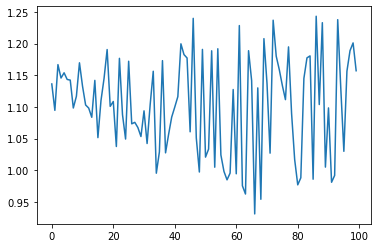

In [106]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)